# 🐝💨 Introduction to Xylo-IMU

In [1]:
# - General installation and imports
import sys
!{sys.executable} -m pip install --quiet matplotlib rich "rockpool[xylo, torch]"

# - Import numpy
import numpy as np

# - Configure matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

# - Display images
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

# - Nice printing
from rich import print

## Overview of the Xylo-IMU design
Xylo-IMU 1 receives direct input from a MEMSIC MC3632 IMU sensor, and is designed to enable motion classification applications in real-time at low power.

The block-level outline of the chip is shown below.
A dedicated IMU interface connects to the IMU sensor via a master SPI bus, and converts motion data into streams of events.

Event-encoded motion data is transferred to a digital SNN core for inference. The results of inference, encoded as output event streams, are transmitted over an interrupt bus or slave SPI bus to an external microcontroller.

A block of control logic manages configuration and communication with the cores. Configuration and readout from Xylo-IMU is performed over a slave SPI bus.

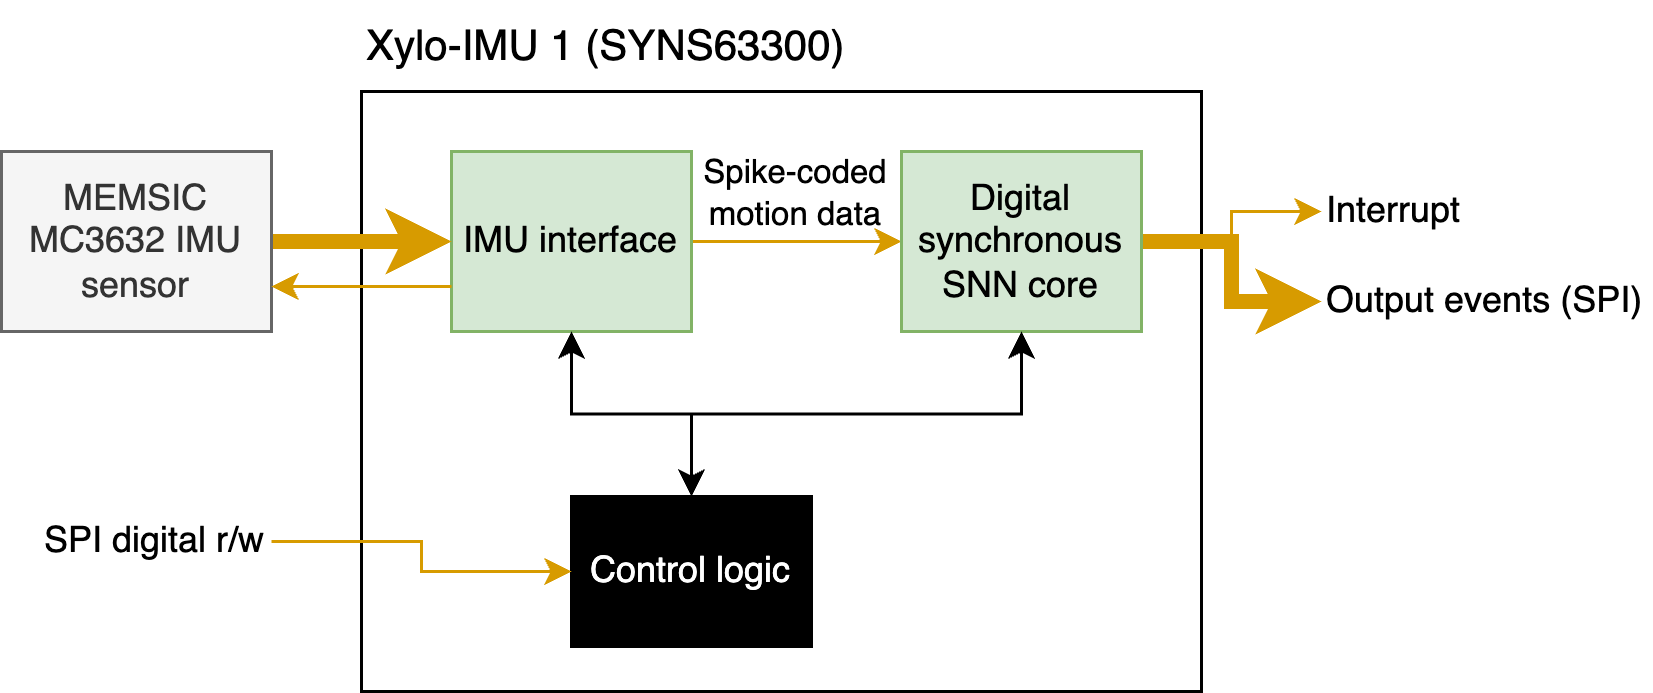

In [2]:
Image('xylo-imu-block-level.png')

## Differences from other Xylo devices
Xylo-IMU is based around the same digital integer LIF inference core as the rest of the Xylo™ family.
Xylo-IMU includes several design changes from Xylo-Audio 2 and other Xylo-family devices:

 * One synaptic state per neuron
 * 16 spiking input channels to SNN core
 * 496 hidden neurons
 * 16 spiking output channels
 * Input weight projections to up to first 128 hidden neurons
 * Output weight projection from up to 128 hidden neurons
 * Up to 512 fanout recurrent weights per hidden neuron
 * Up to 31,744 recurrent weights total

## Part I: Using the SNN inference core on Xylo-IMU


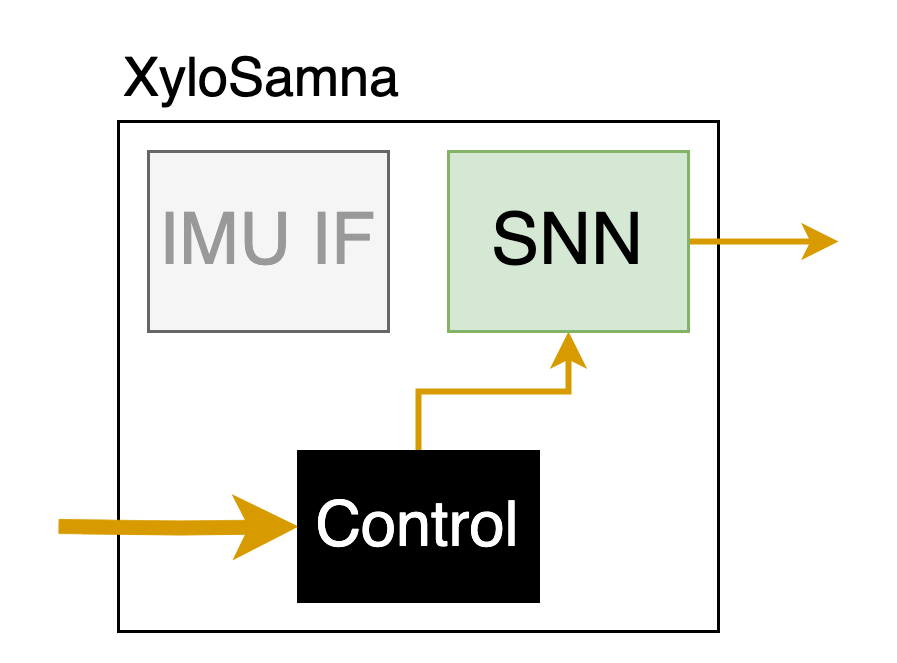

In [3]:
Image('XyloSamna.png', width=400)


### Step 1: Build a network in rockpool and convert it to a hardware configuration

In [4]:
# - Used to build trainable models
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

# - Modules required to interface and deploy models to the Xylo-IMU HDK
from rockpool.devices.xylo import find_xylo_hdks
from rockpool.devices.xylo.syns63300 import XyloSamna, config_from_specification, mapper, XyloSim
import rockpool.devices.xylo.syns63300.xylo_imu_devkit_utils as putils
from rockpool.transform import quantize_methods as q

# - Used for plotting time series
from rockpool import TSEvent, TSContinuous

In [5]:
# - Define the size of the network layers
Nin = 2
Nhidden = 4
Nout = 2
dt = 1e-2

In [6]:
# - Define the network architecture using combinators and modules
net = Sequential(
    LinearTorch((Nin, Nhidden), has_bias = False),
    LIFTorch(Nhidden, dt = dt),
    
    Residual(
        LinearTorch((Nhidden, Nhidden), has_bias = False),
        LIFTorch(Nhidden, has_rec = True, threshold = 1., dt = dt),
    ),
    
    LinearTorch((Nhidden, Nout), has_bias = False),
    LIFTorch(Nout, dt = dt),
)
print(net)

TorchSequential  with shape (2, 2) {
    LinearTorch '0_LinearTorch' with shape (2, 4)
    LIFTorch '1_LIFTorch' with shape (4, 4)
    TorchResidual '2_TorchResidual' with shape (4, 4) {
        LinearTorch '0_LinearTorch' with shape (4, 4)
        LIFTorch '1_LIFTorch' with shape (4, 4)
    }
    LinearTorch '3_LinearTorch' with shape (4, 2)
    LIFTorch '4_LIFTorch' with shape (2, 2)
}

In [7]:
# - Call the Xylo mapper on the extracted computational graph
spec = mapper(net.as_graph(),  weight_dtype='float', threshold_dtype='float', dash_dtype='float')

# - Quantize the specification
spec.update(q.global_quantize(**spec))

# # you can also try channel-wise quantization
# spec.update(q.channel_quantize(**spec))
# print(spec)

# - Use `config_from_specification()` to convert it to a hardware configuration
config, is_valid, msg = config_from_specification(**spec)
if not is_valid:
    print(msg)

### Step 2: Deploy the network to the Xylo SNN core on a connected HDK

In [9]:
# - Find and connect to a Xylo IMU HDK
xylo_hdk_nodes, _, vers = find_xylo_hdks()
print(xylo_hdk_nodes, vers)

if len(xylo_hdk_nodes) == 0 or vers[0] != "syns63300":
    assert False, "This tutorial requires a connected Xylo IMU HDK to demonstrate."
else:
    db = xylo_hdk_nodes[0]


The connected Xylo HDK contains a Xylo IMU. Importing `rockpool.devices.xylo.syns63300`


[<samna.xyloImuBoards.XyloImuTestBoard object at 0x3508e55b0>]
['syns63300']

In [10]:
# - Use the `XyloSamna` module to deploy to the inference core on the HDK
modSamna = XyloSamna(db, config, dt = dt)
print(modSamna)

XyloSamna  with shape (2, 4, 2)

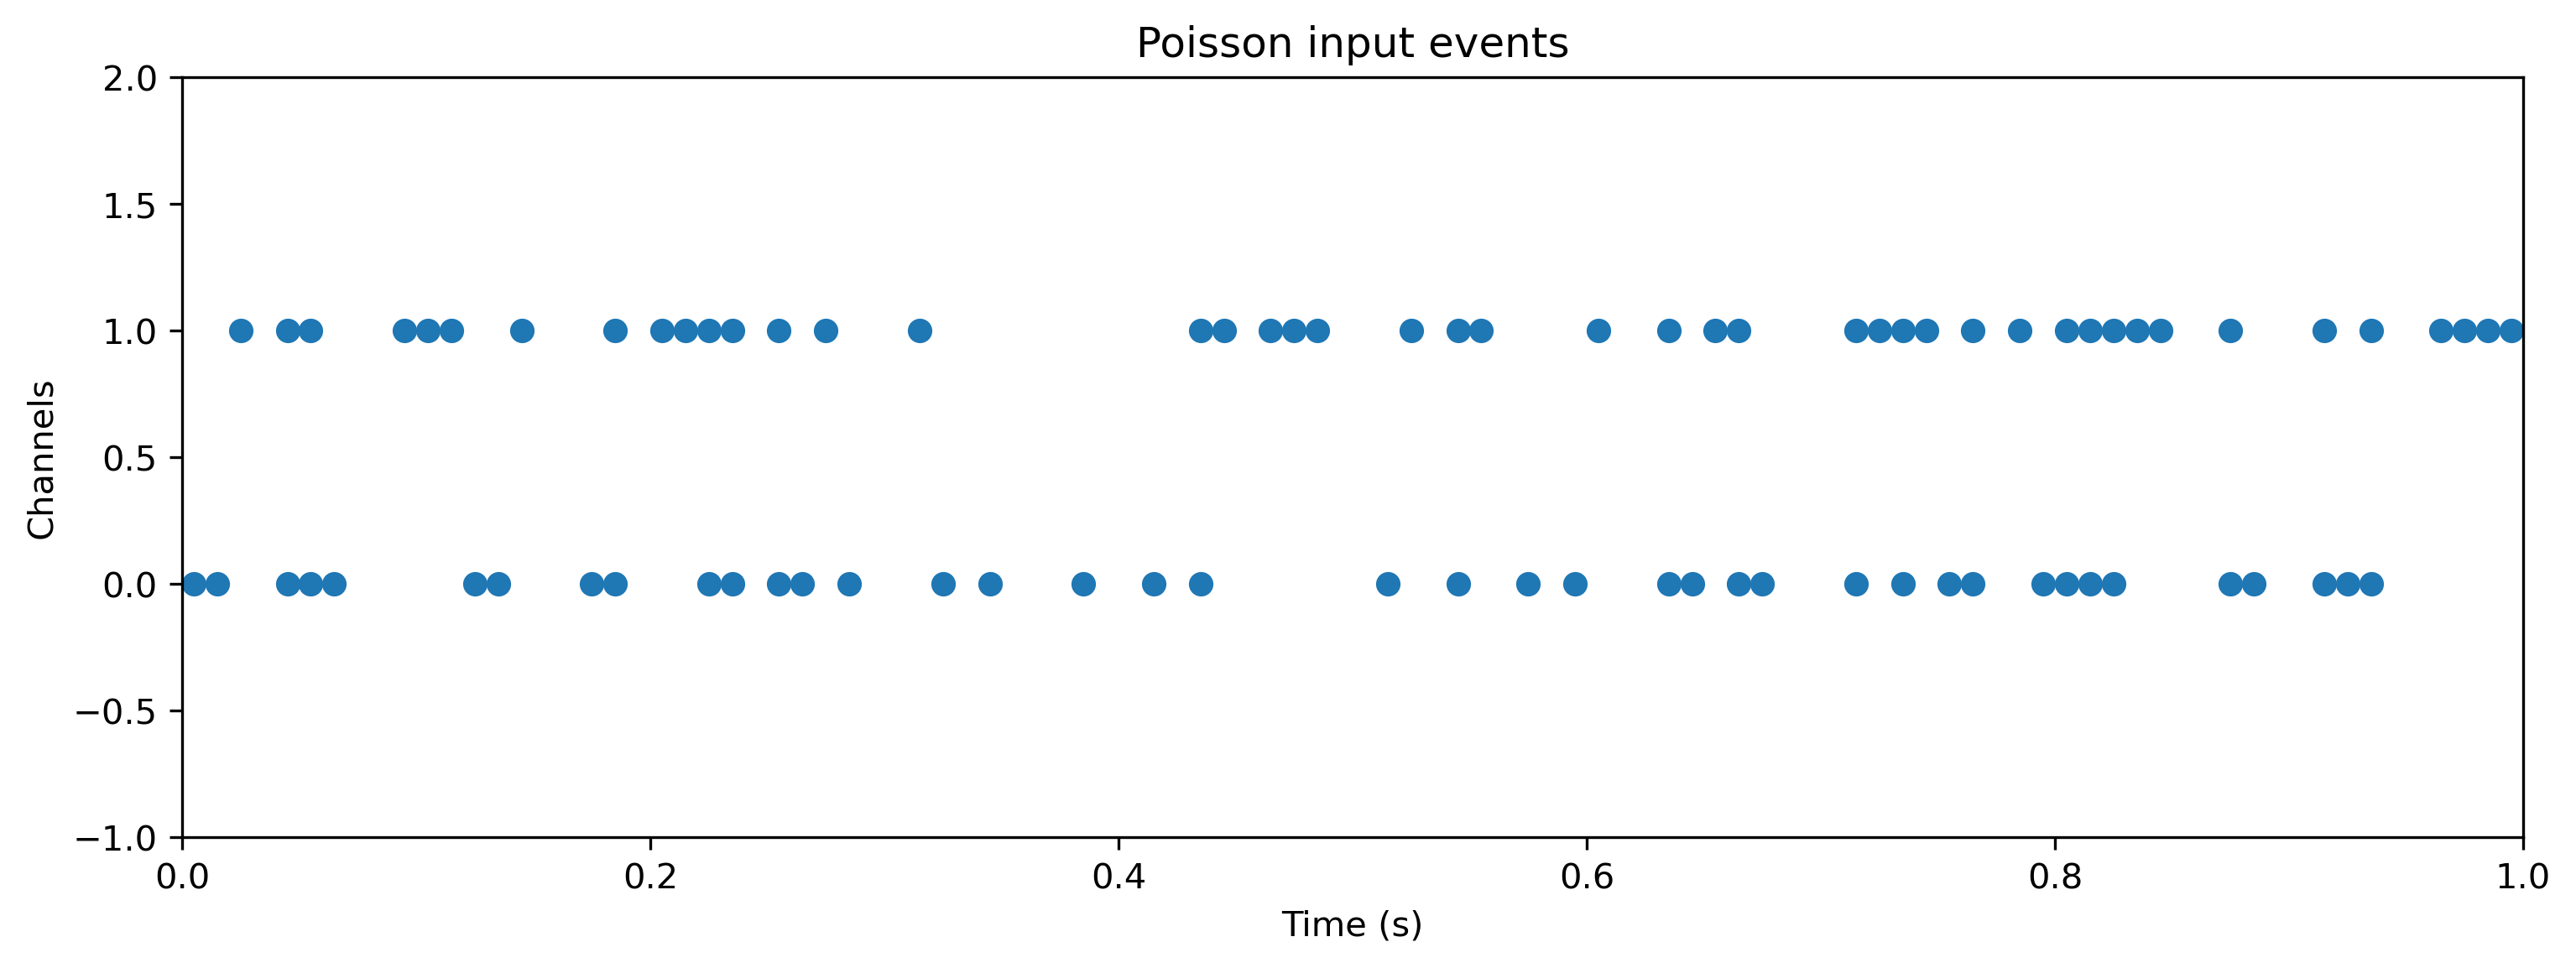

In [11]:
# - Generate some Poisson input
T = 100
f = 0.4
input_spikes = np.random.rand(T, Nin) < f
TSEvent.from_raster(input_spikes, dt, name = 'Poisson input events').plot();

In [12]:
# - Evolve the network on the Xylo HDK
out, _, r_d = modSamna.evolve(input_spikes.astype(int), record = True)

# - Show the internal state variables recorded 
print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Spikes', 'Vmem_out', 'Isyn_out', 'times'])

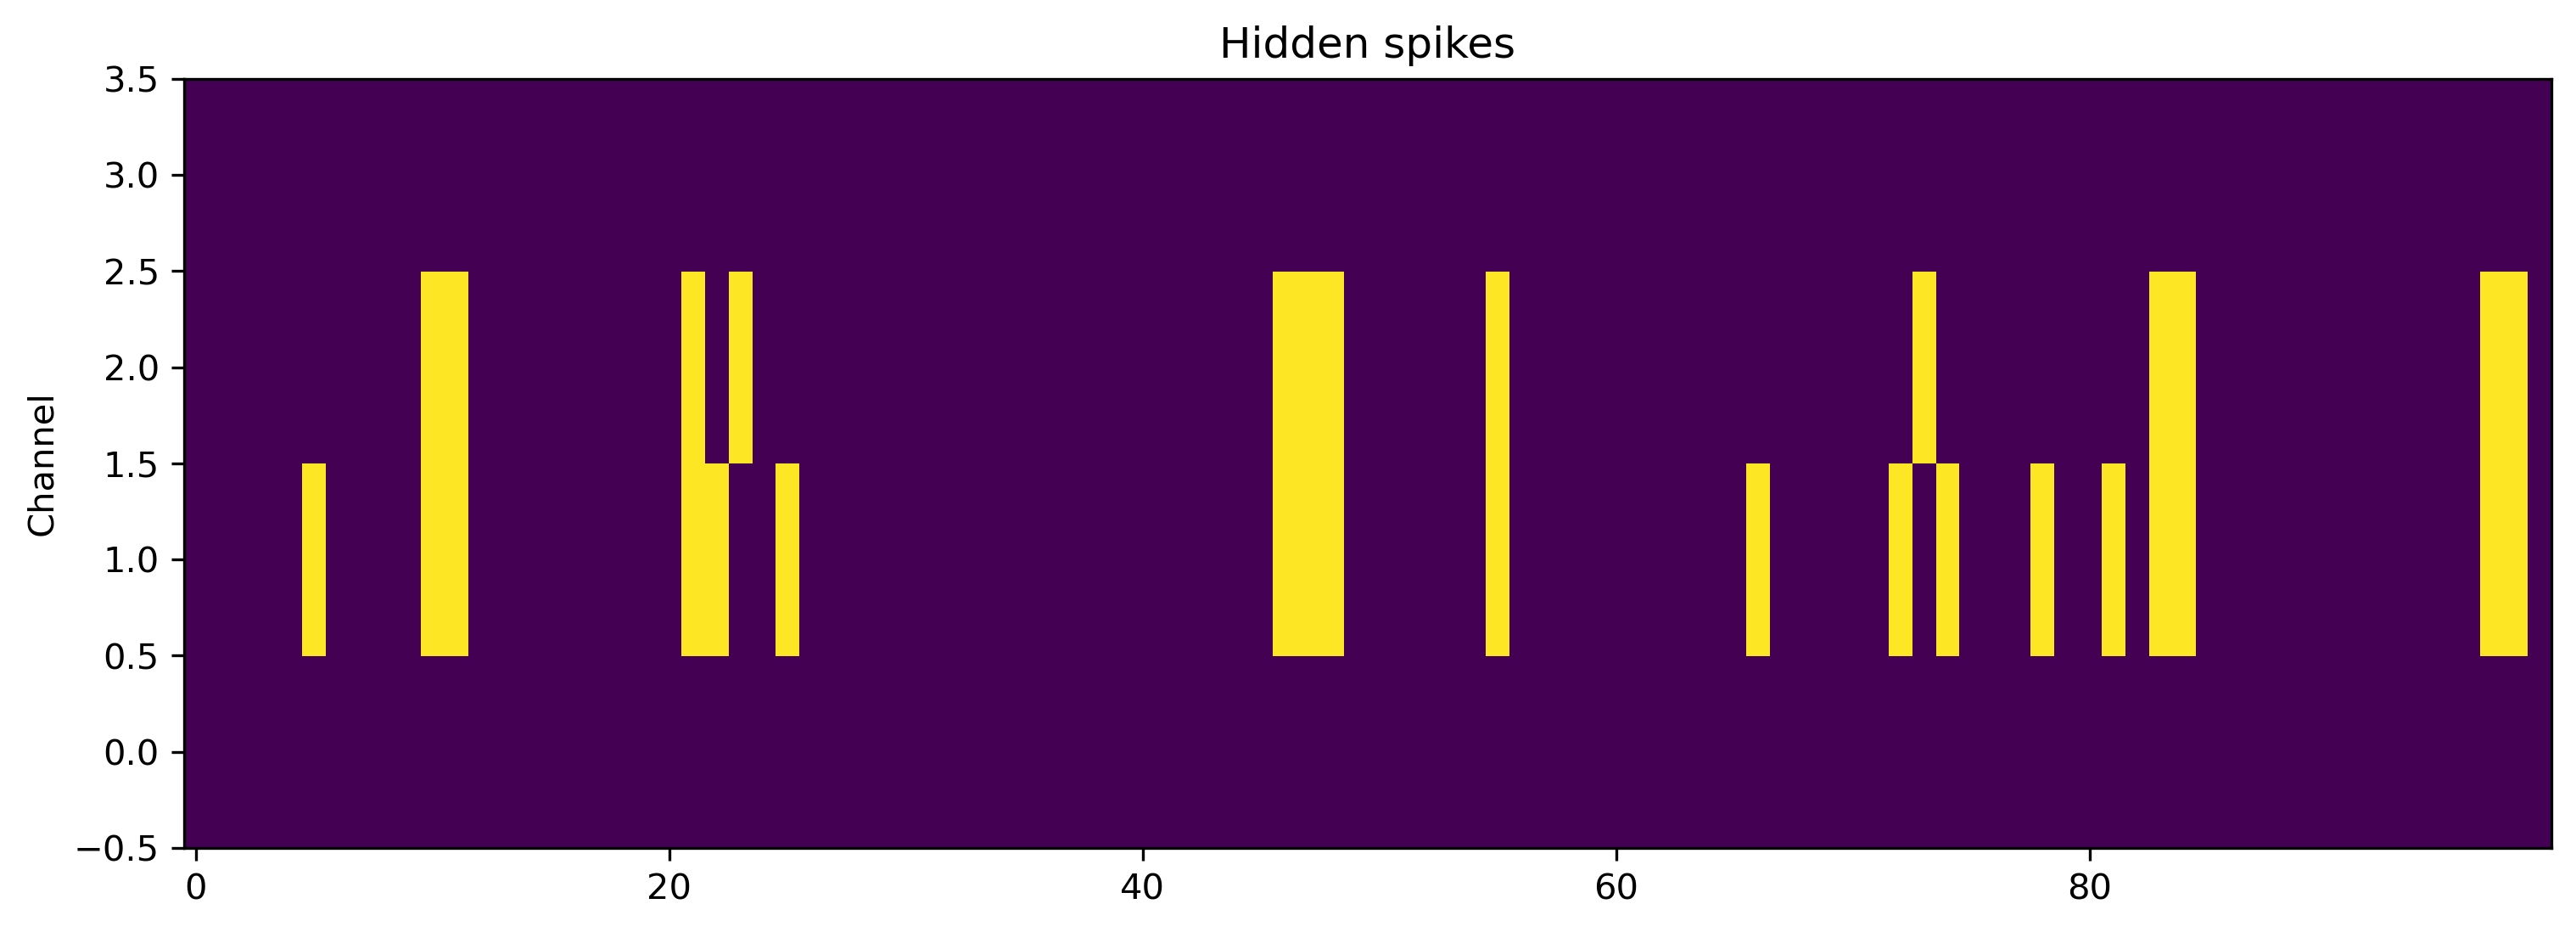

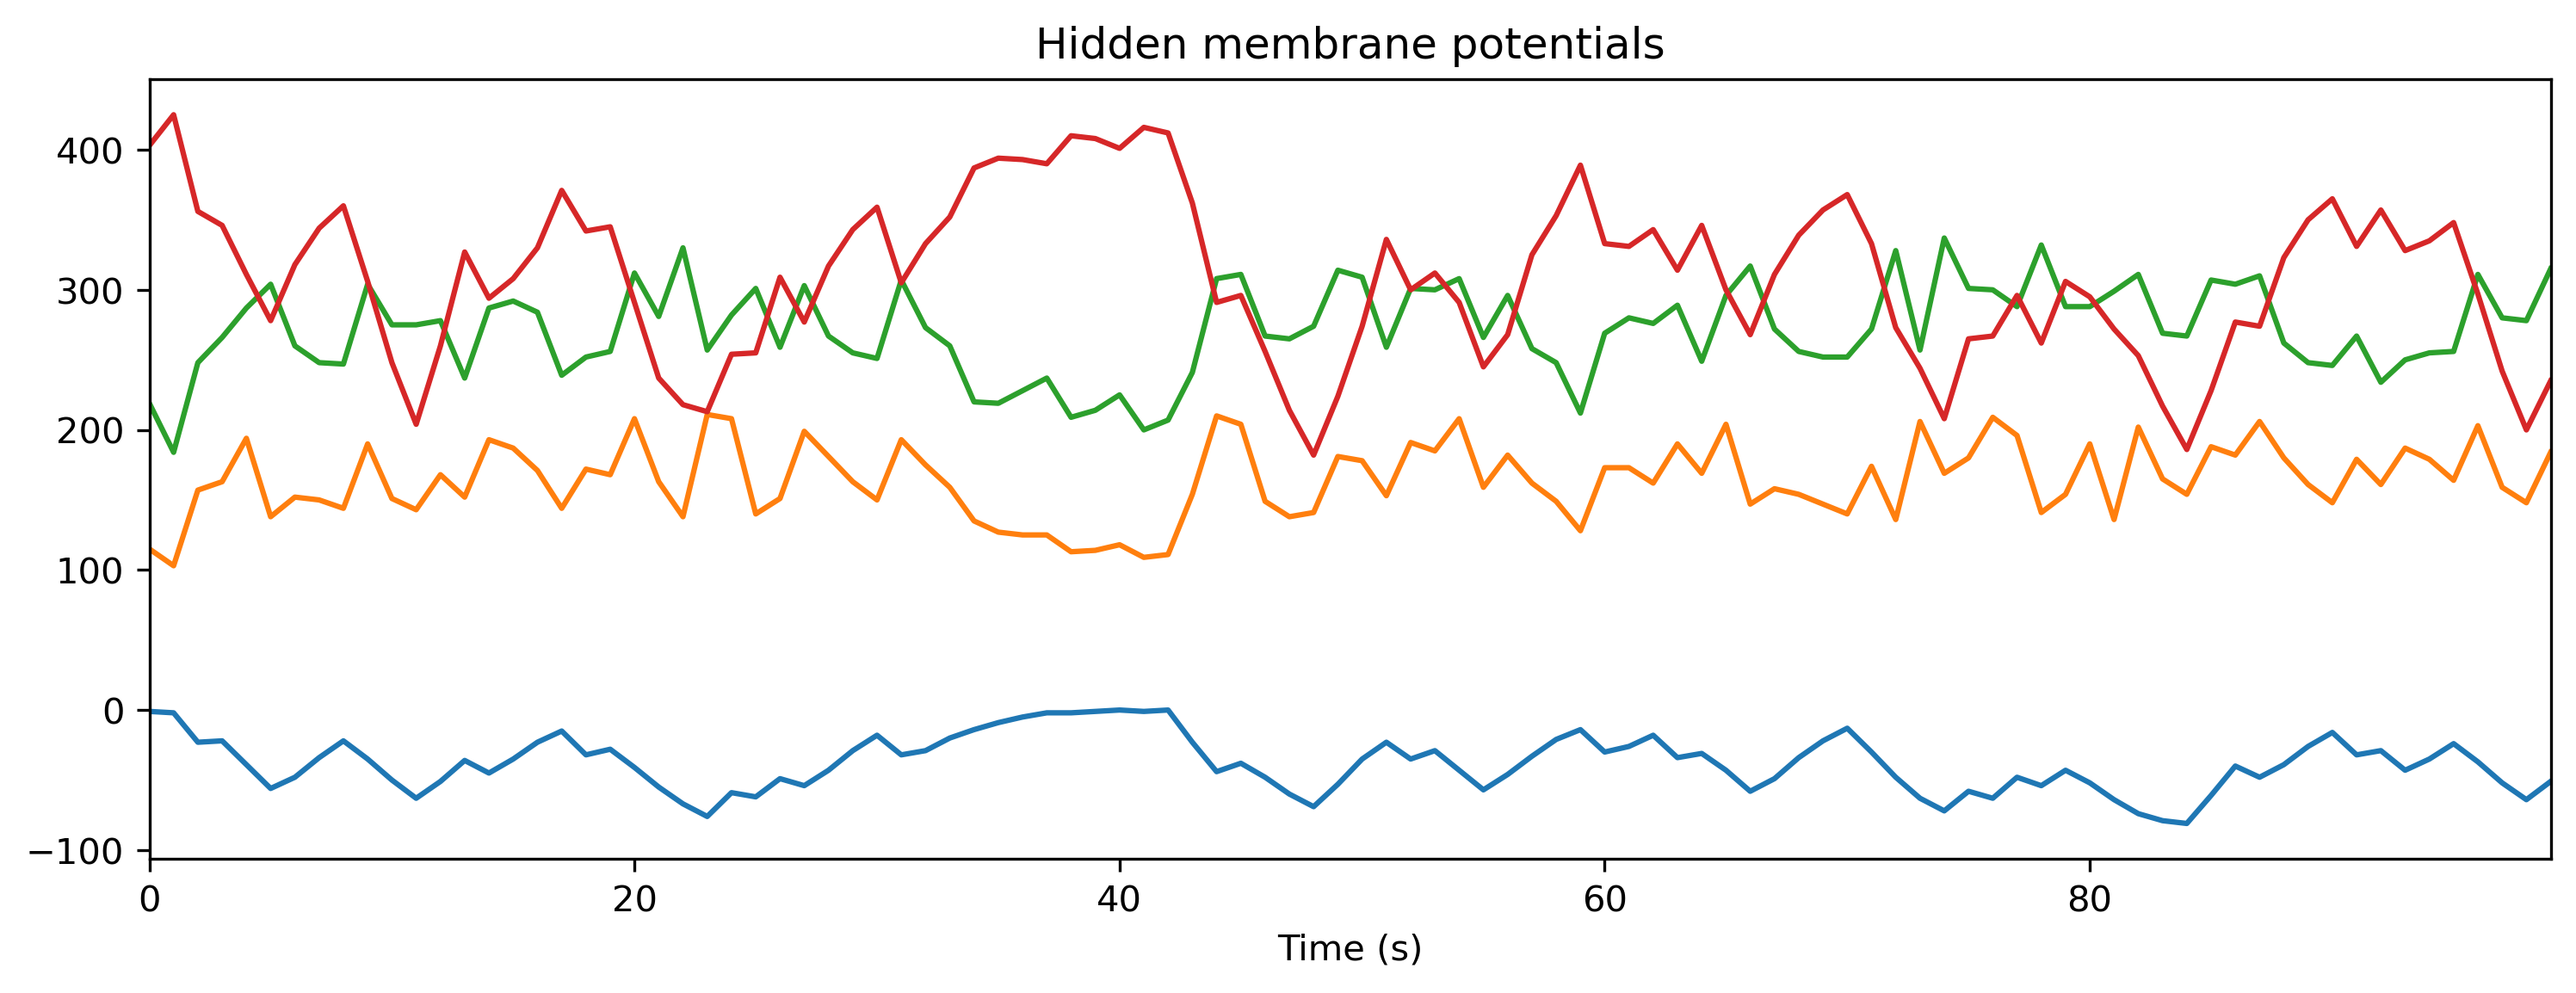

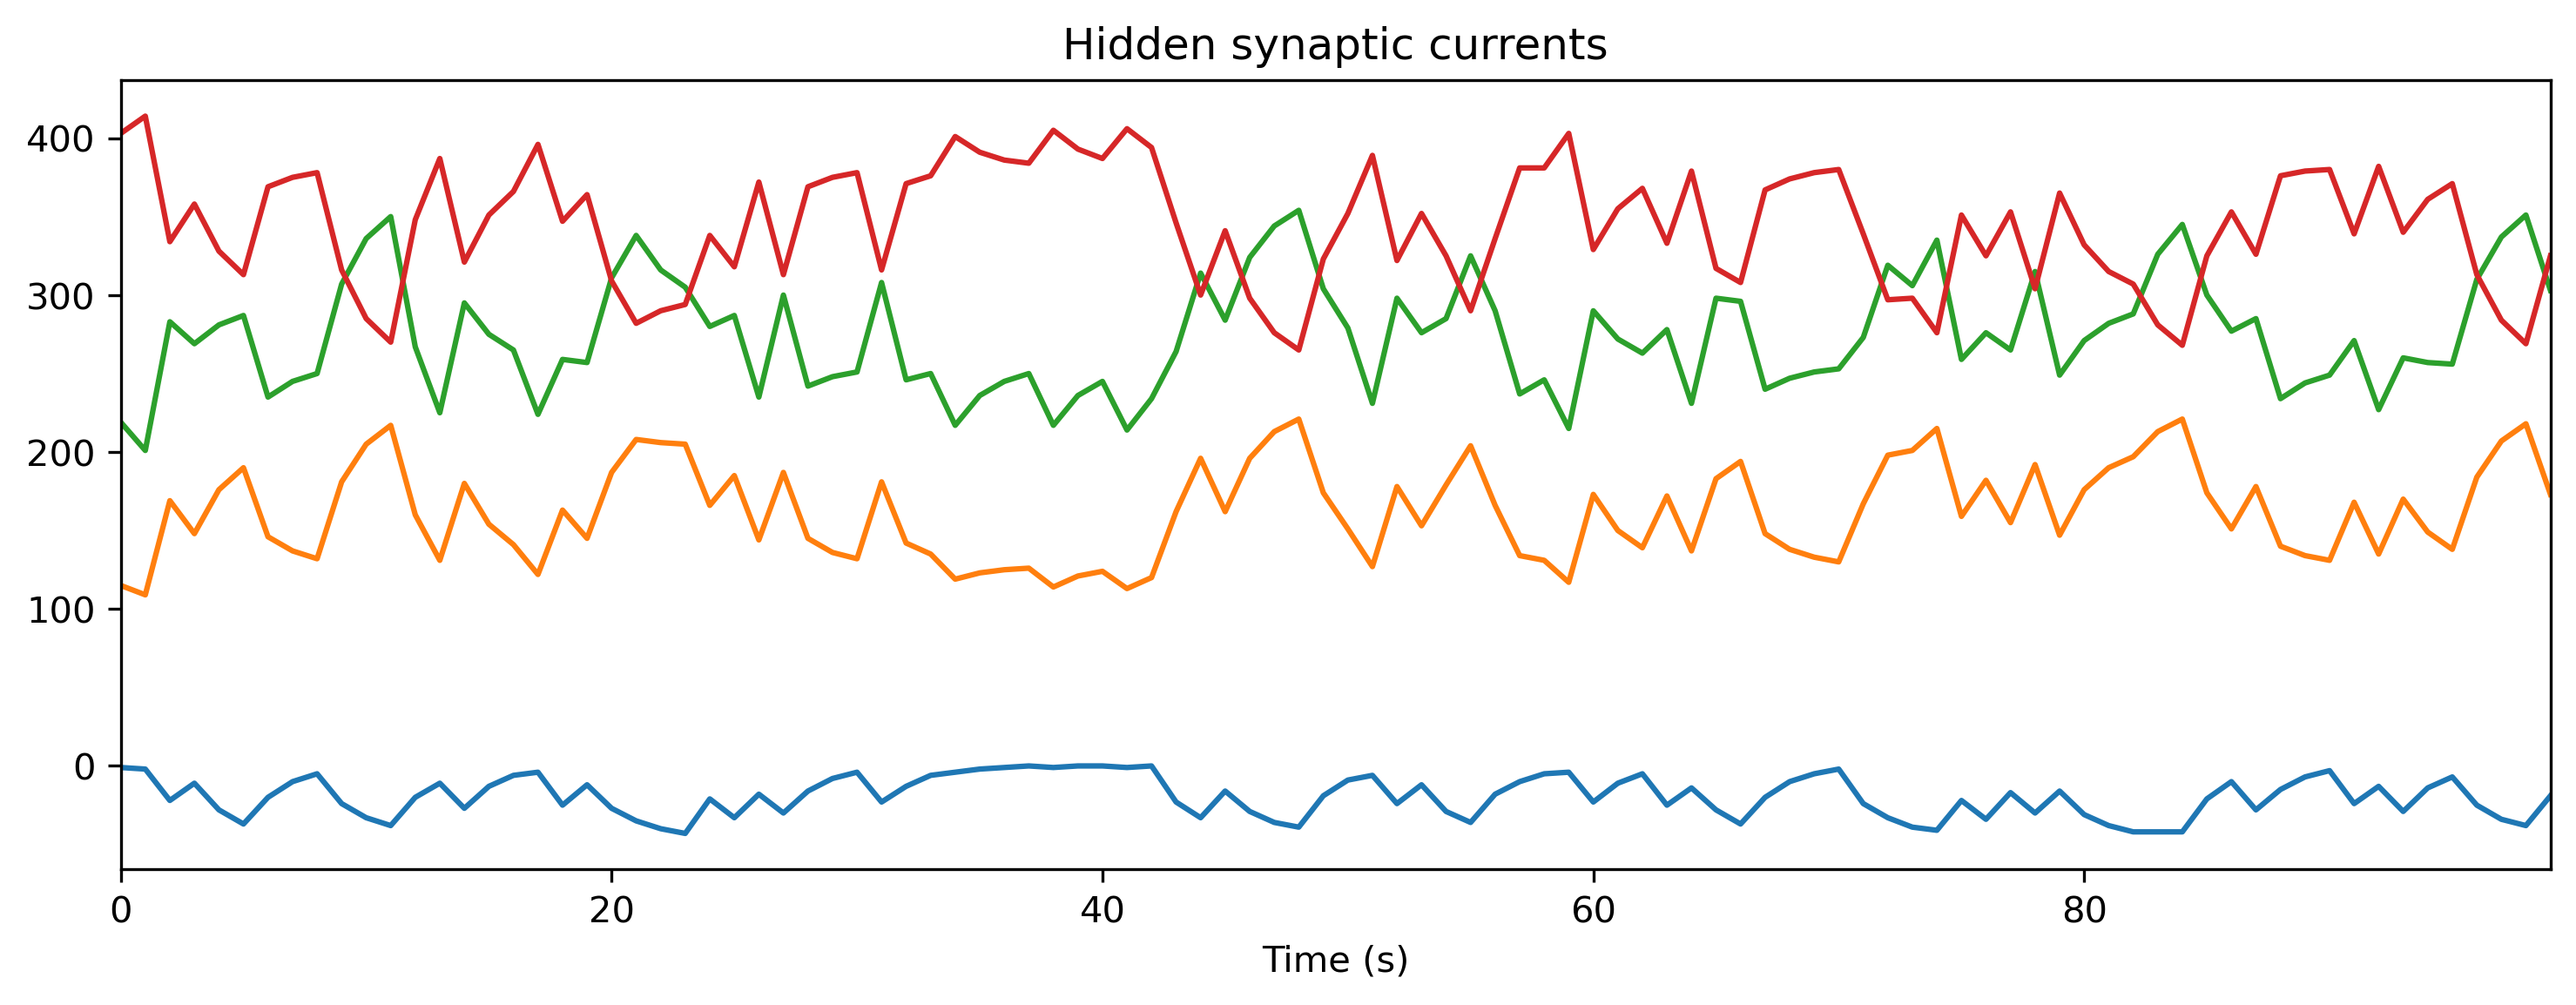

In [13]:
# - Plot some internal state variables
plt.figure()
plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
plt.title('Hidden spikes')
plt.ylabel('Channel')

plt.figure()
TSContinuous(r_d['times'], r_d['Vmem'], name = 'Hidden membrane potentials').plot(stagger = 127)

plt.figure()
TSContinuous(r_d['times'], r_d['Isyn'], name = 'Hidden synaptic currents').plot(stagger = 127);

### Step 3: Simulate the HDK using a bit-precise simulator

In [14]:
# - Use the XyloIMUSim device simulator
modSim = XyloSim.from_config(config, dt=dt)
print(modSim)

XyloSim  with shape (16, 1000, 8)

In [15]:
# - Evolve the input over the network, in simulation
out, _, r_d = modSim(input_spikes, record = True)

# - Show the internal state variables recorded 
print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Spikes', 'Vmem_out', 'Isyn_out'])

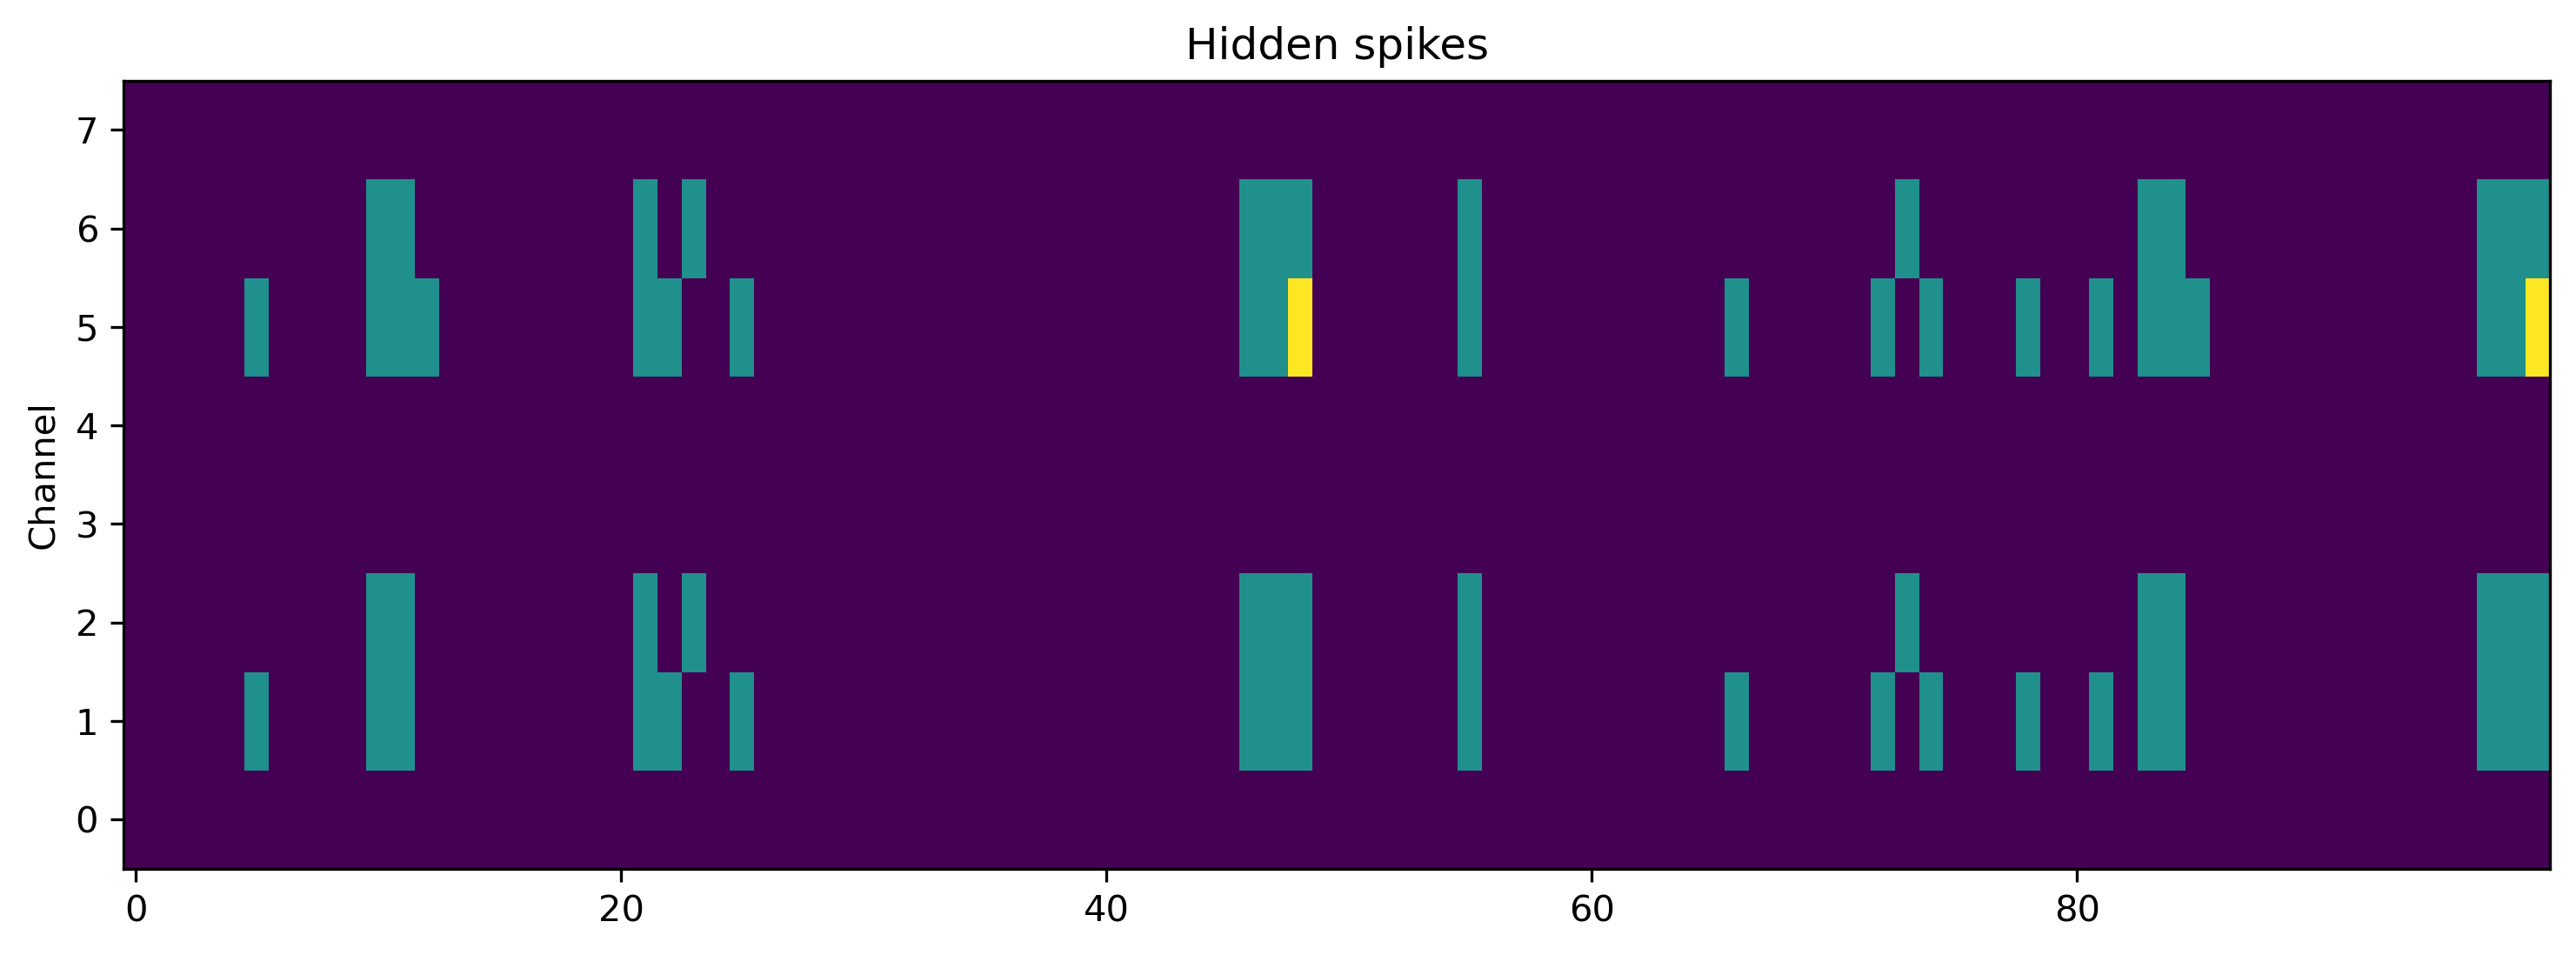

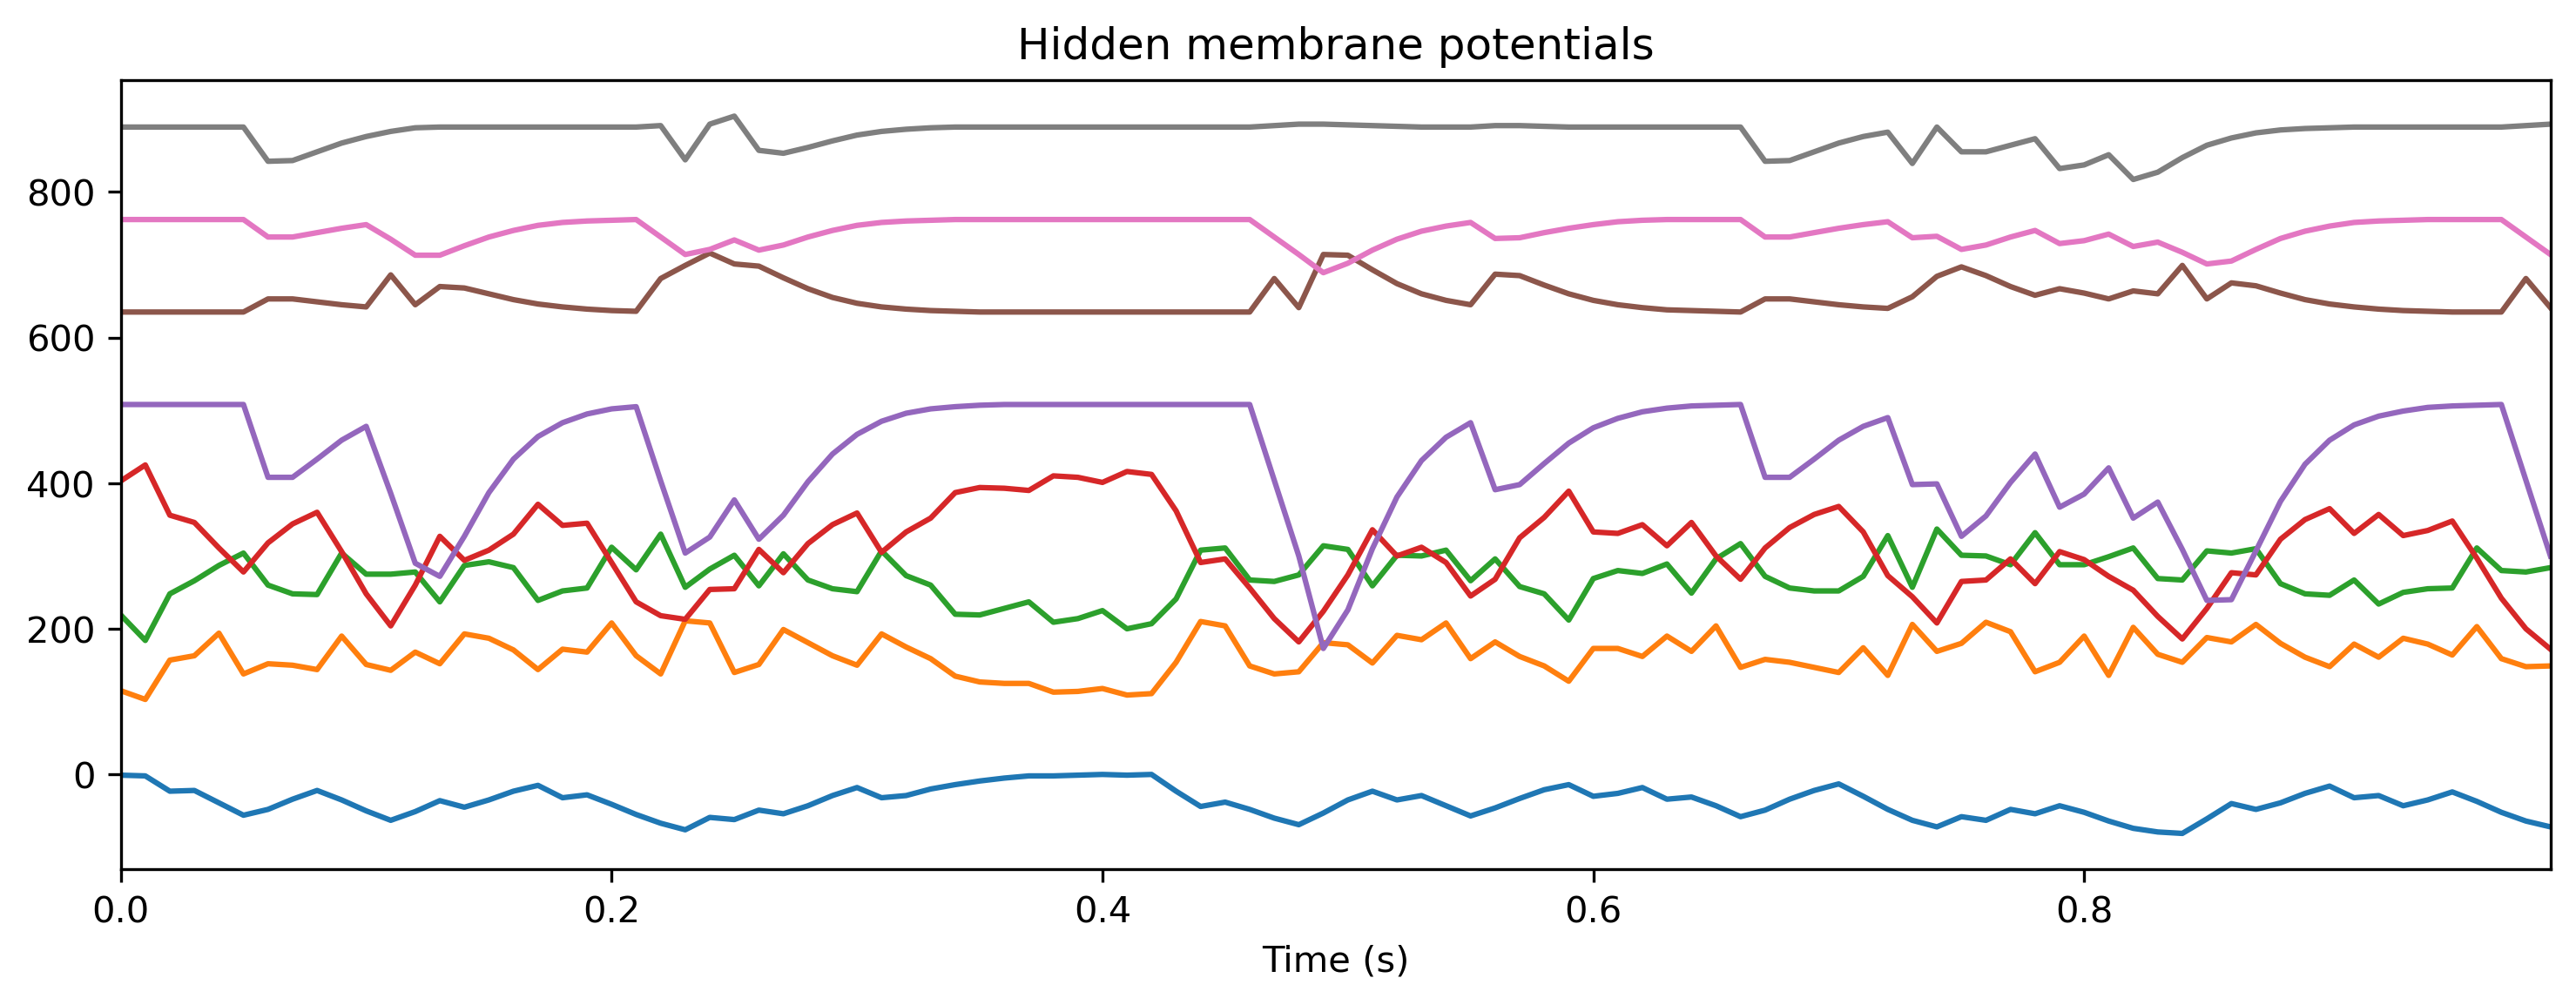

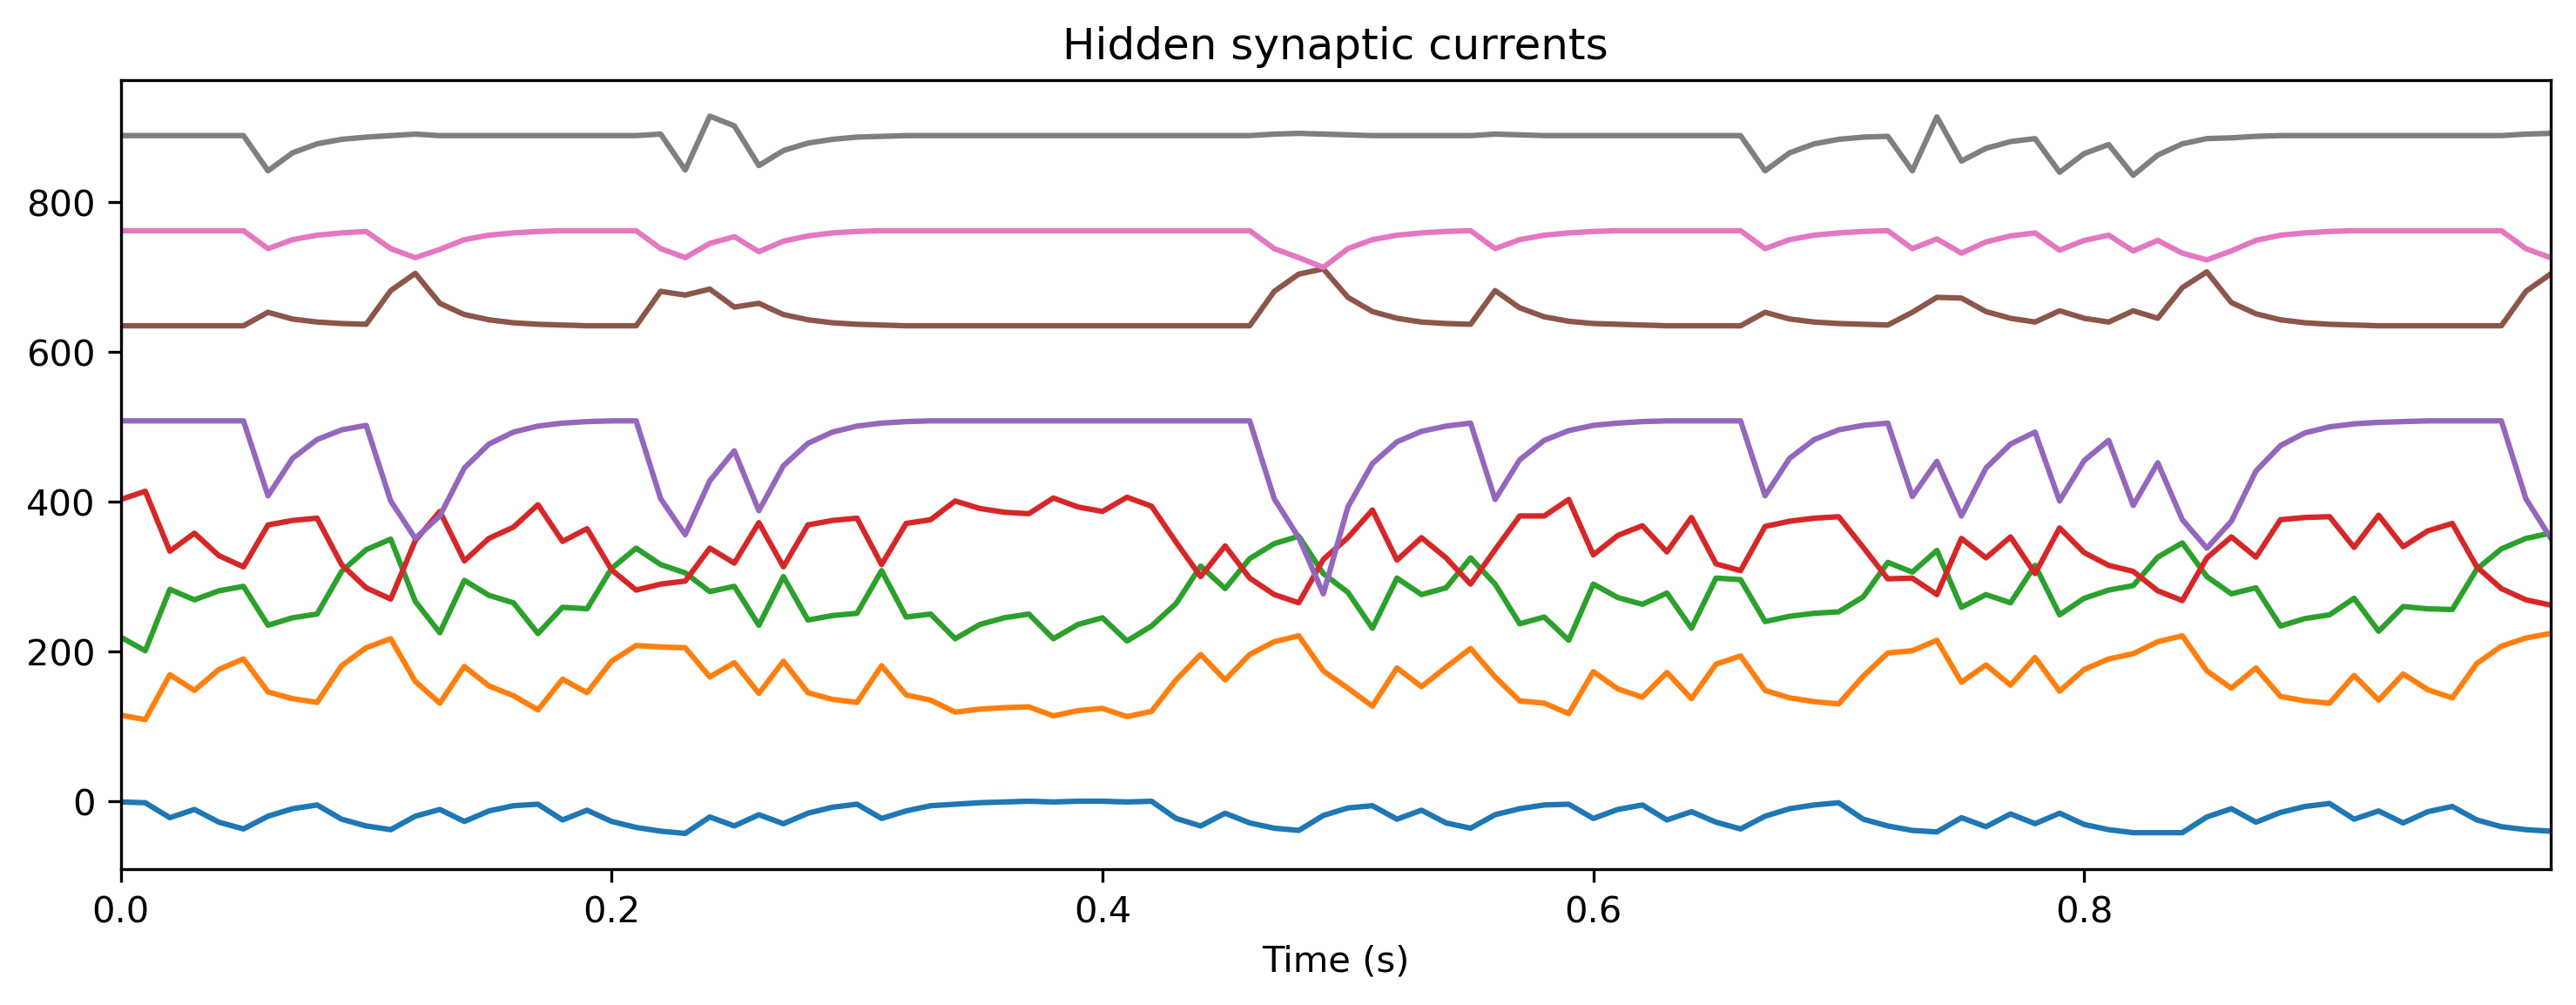

In [16]:
# - Plot some internal state variables
plt.figure()
plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
plt.title('Hidden spikes')
plt.ylabel('Channel')

plt.figure()
TSContinuous.from_clocked(r_d['Vmem'], dt, name = 'Hidden membrane potentials').plot(stagger = 127)

plt.figure()
TSContinuous.from_clocked(r_d['Isyn'], dt, name = 'Hidden synaptic currents').plot(stagger = 127);

## PART II: The IMU encoding interface

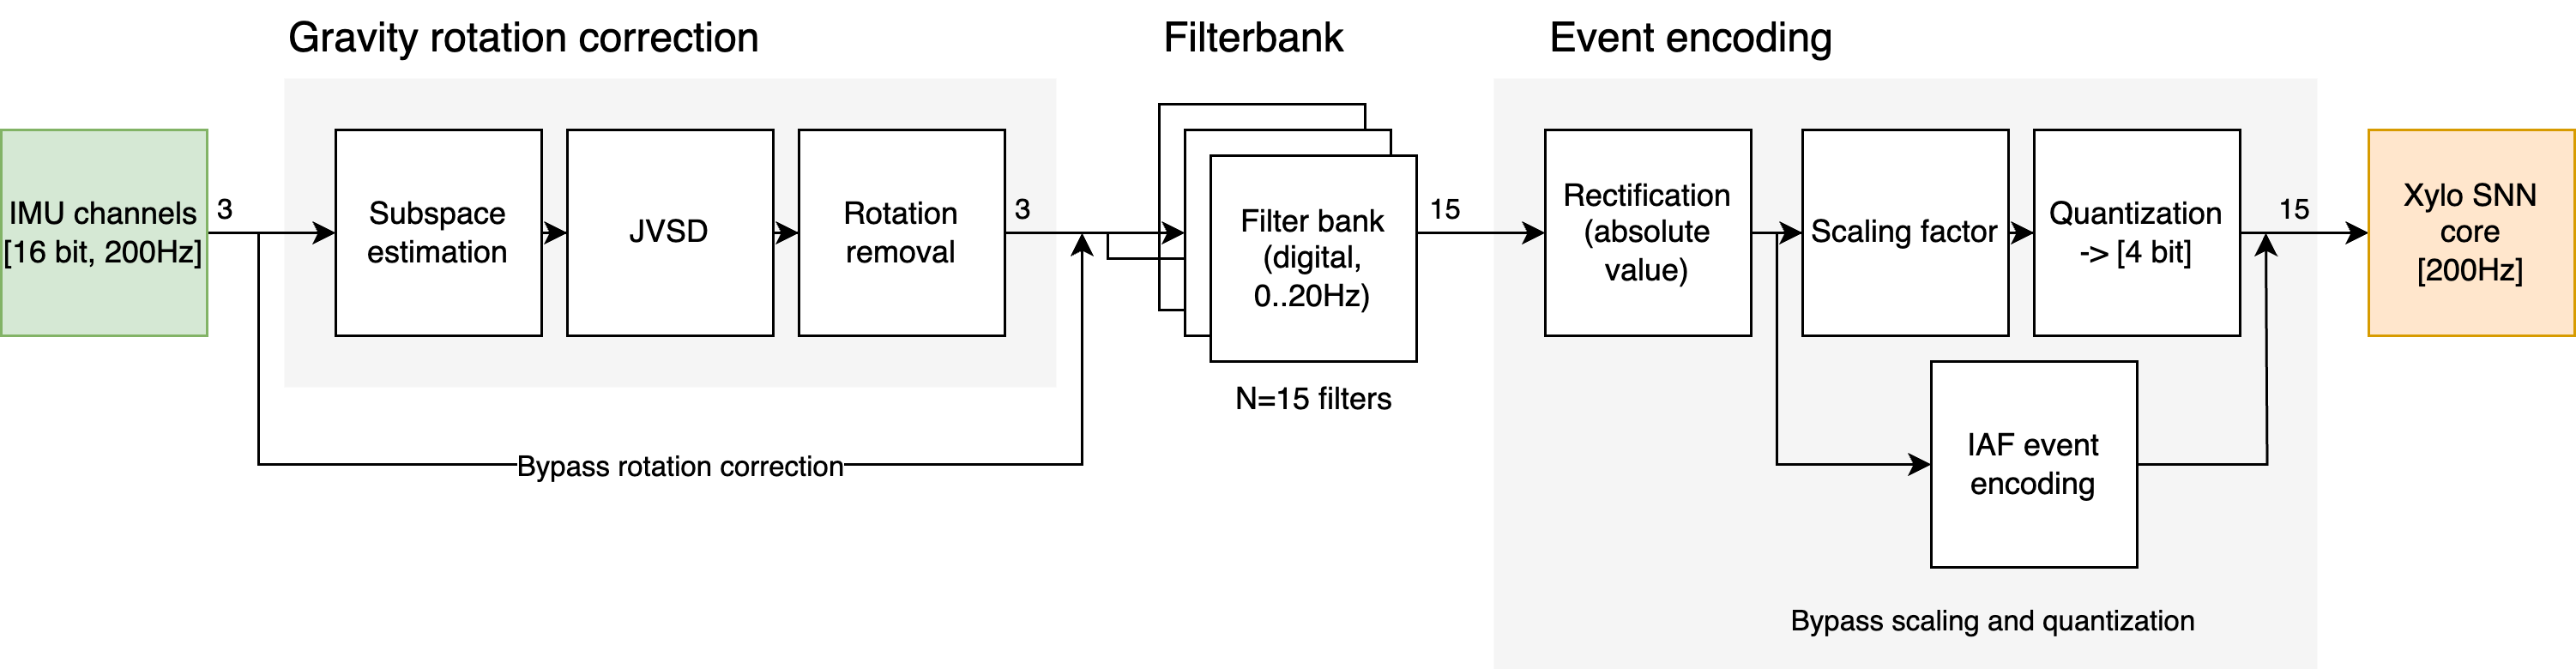

In [17]:
Image('IMU-IF-block-level.png')

### Using the IMU IF Simulation module

In [18]:
from rockpool.devices.xylo.syns63300 import IMUIFSim

# - Load a dummy IMU sample
input_data = np.load('data.npy')

# - Create an IMUIFSim module
mod = IMUIFSim()
print(mod)

IMUIFSim  with shape (3, 15) {
    ModSequential 'model' with shape (3, 15) {
        RotationRemoval '0_RotationRemoval' with shape (3, 3) {
            ModSequential 'sub_estimate' with shape (3, 9) {
                SubSpace '0_SubSpace' with shape (3, 9)
                SampleAndHold '1_SampleAndHold' with shape (9, 9)
            }
        }
        FilterBank '1_FilterBank' with shape (3, 15)
        ScaleSpikeEncoder '2_ScaleSpikeEncoder' with shape (15, 15)
    }
}

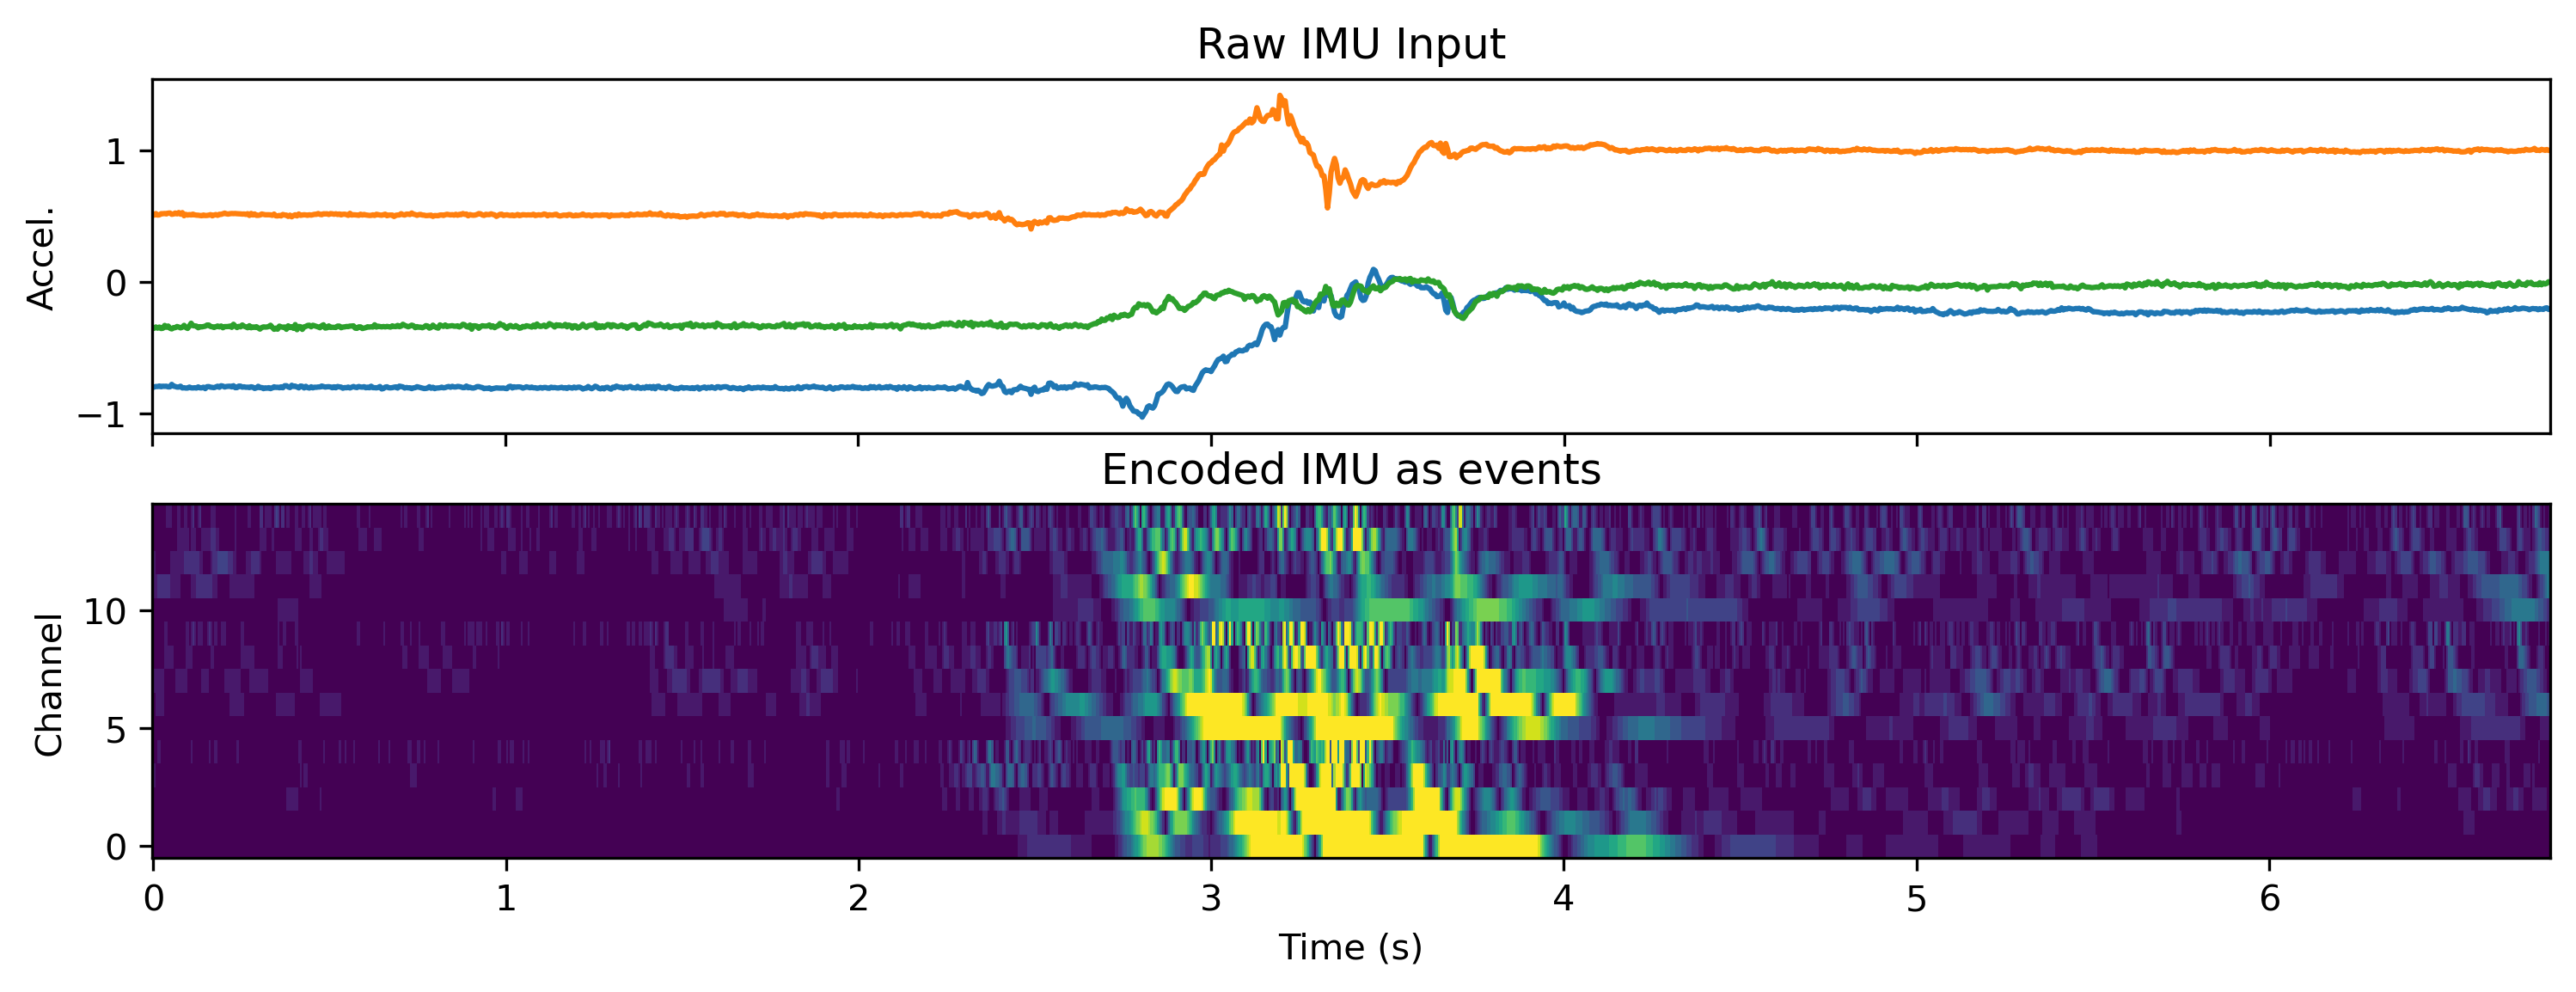

In [19]:
# - Quantize the raw IMU data
from rockpool.devices.xylo.syns63300 import Quantizer
quantizer = Quantizer(shape=3, scale=0.49, num_bits=16)
Q_data, _, _ = quantizer(input_data)

# - Test evolution and plot input and output
out, _, r_d = mod(Q_data, record = True)

times = np.arange(0, input_data.shape[0]) * mod.dt
ax = plt.subplot(2, 1, 1)
ax.plot(times, input_data)
ax.set_xlim(0, times[-1])
ax.set_xticklabels([])
ax.set_title('Raw IMU Input')
ax.set_ylabel('Accel.')

ax = plt.subplot(2, 1, 2)
ax.imshow(out[0].astype(int).T, aspect='auto', interpolation='none', origin='lower')
ax.set_xticklabels(np.array(ax.get_xticks() * mod.dt).astype(int))
ax.set_title('Encoded IMU as events')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Channel');

In [20]:
if_config = mod.export_config()
print(if_config)

xyloImu::configuration::InputInterfaceConfig(enable=1, configuration_timeout=3.000000, estimator_k_setting=4, 
select_iaf_output=0, bypass_jsvd=0, update_matrix_threshold=10, delay_threshold=500, bpf_bb_values={ 6 5 4 3 2 6 5 
4 3 2 6 5 4 3 2 }, bpf_bwf_values={ 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 }, bpf_baf_values={ 9 10 11 12 13 9 10 11 12 13 9
10 11 12 13 }, bpf_a1_values={ -64458 -63288 -60684 -54529 -39246 -64458 -63288 -60684 -54529 -39246 -64458 -63288 
-60684 -54529 -39246 }, bpf_a2_values={ 31754 30771 28888 25417 19378 31754 30771 28888 25417 19378 31754 30771 
28888 25417 19378 }, scale_values={ 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 }, iaf_threshold_values={ 1024 1024 1024 1024 
1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 })

### Accessing the IMU encoding interface on HW

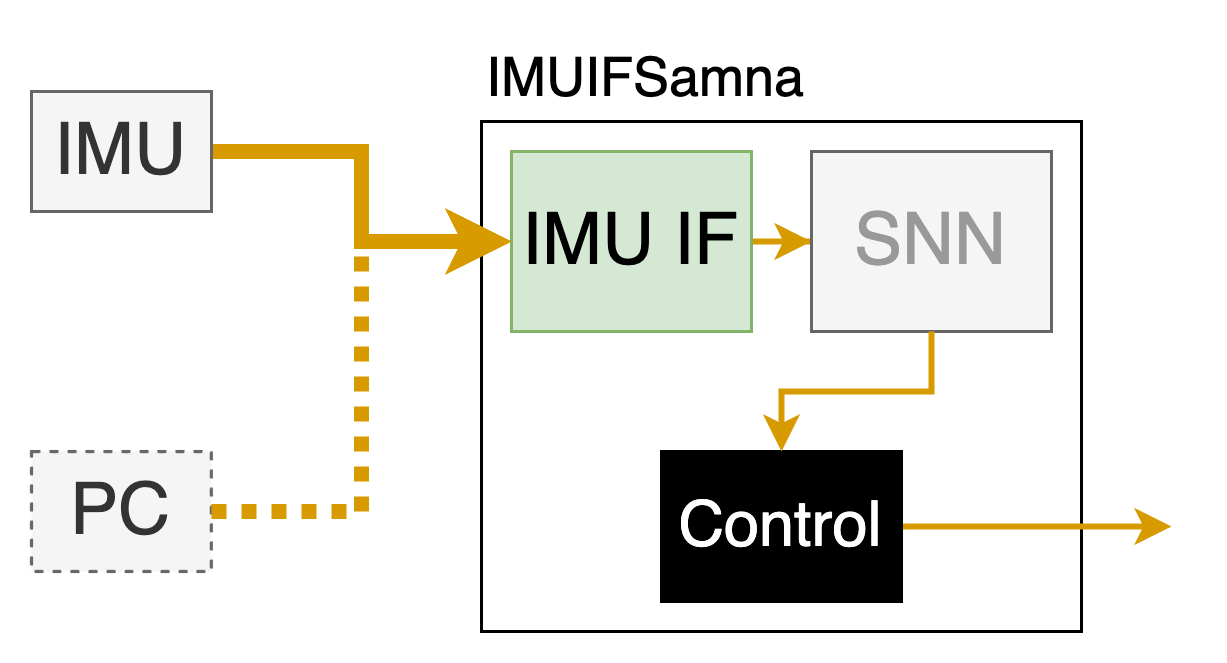

In [21]:
Image('IMUIFSamna.png', width=400)

In [22]:
# - Import the required Rockpool module
from rockpool.devices.xylo.syns63300 import IMUIFSamna

# - Instantiate the module, connected to an HDK `db`
imu_if = IMUIFSamna(db, prerecorded_imu_input = False)

# - You can also supply pre-recorded IMU data, and specify the IMU IF parameters
# IMUIFSamna(db, prerecorded_imu_input = True, interface_params={})

In [23]:
# - Record for 1000 time steps, by providing zero data
out, _, _ = imu_if(np.zeros((1000, 3)))

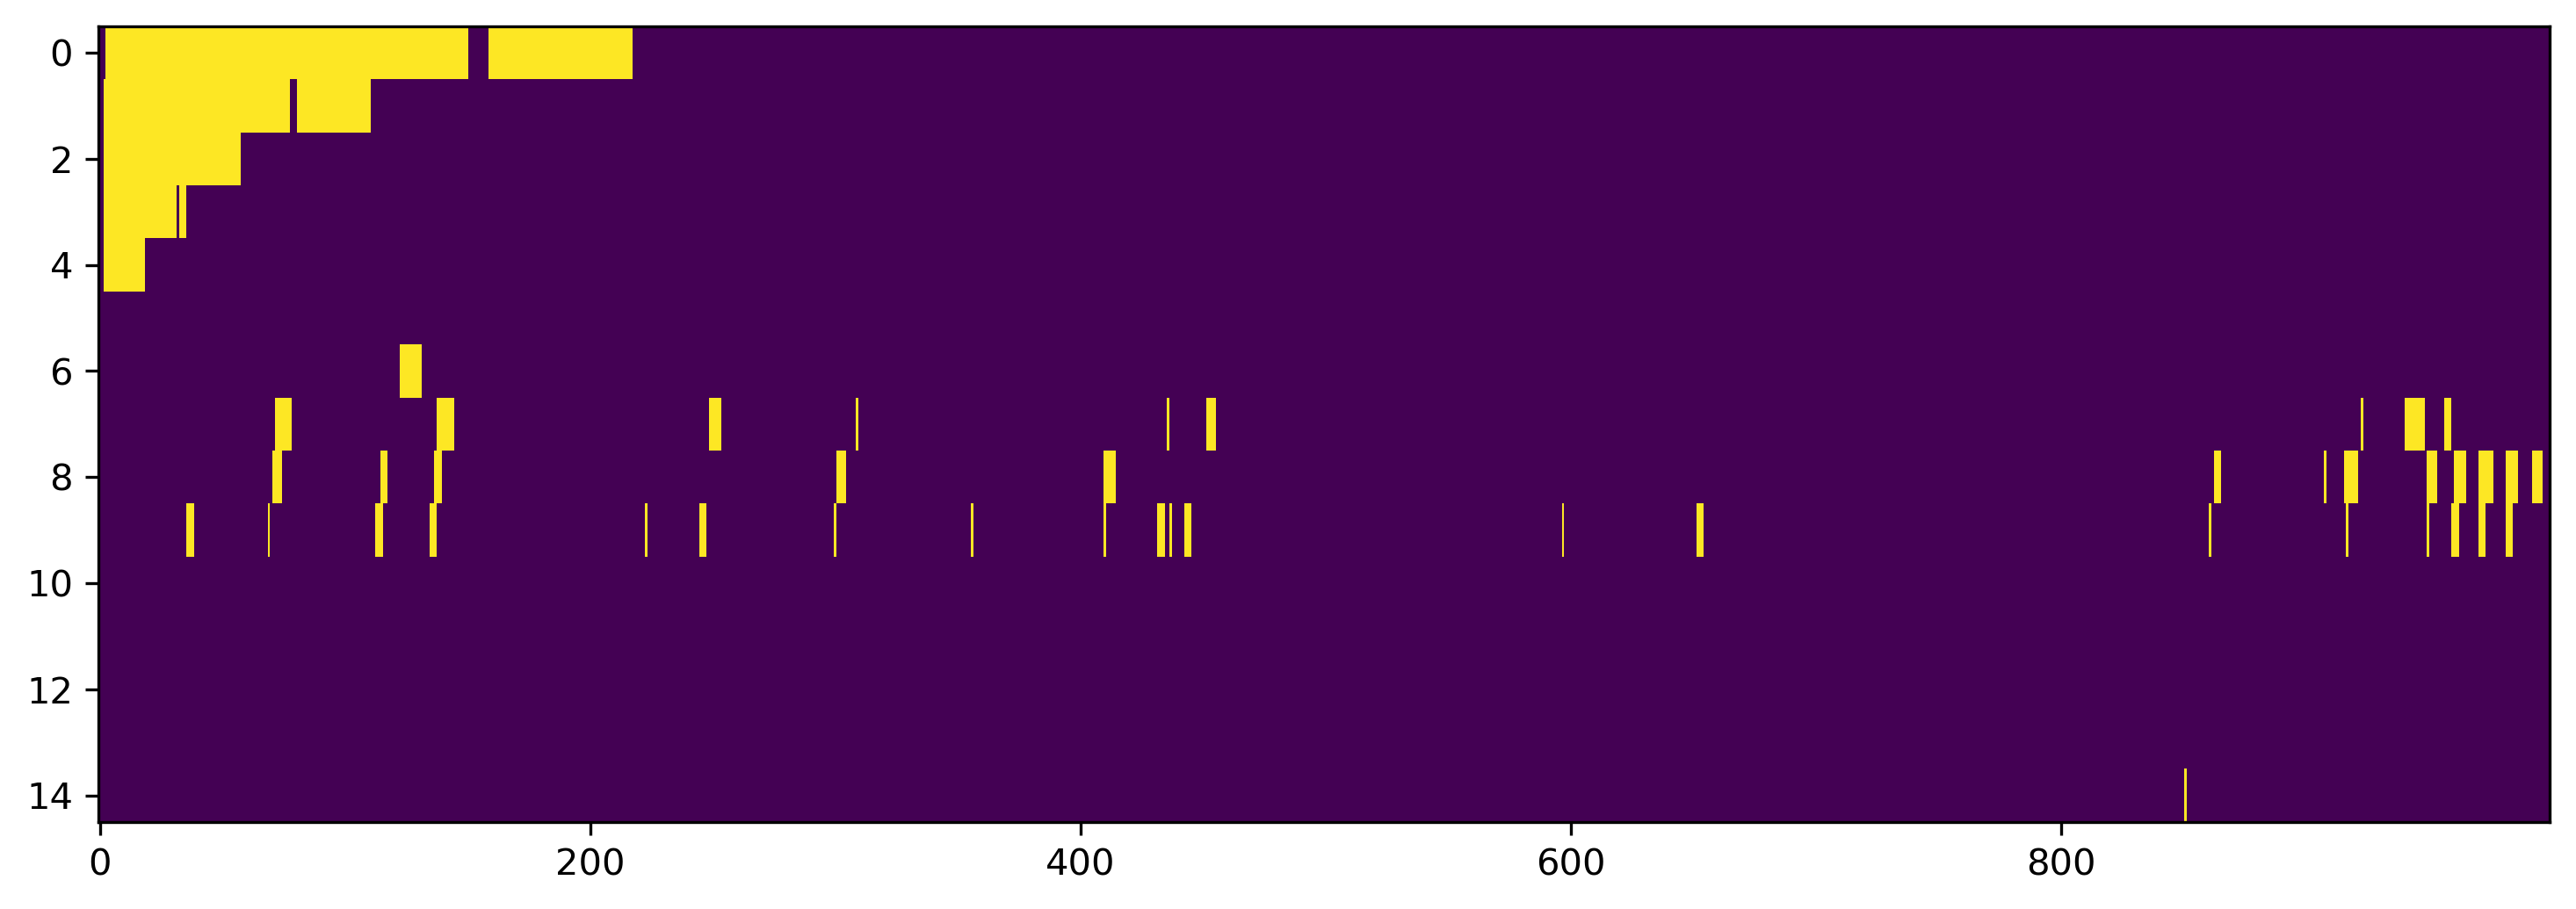

In [24]:
# times, channels = np.where(out)
# plt.scatter(times, channels)

plt.imshow(out.T, aspect = 'auto', interpolation = 'none')

Delete the module to release access to the IMU sensor.

In [25]:
del imu_if

[2024-06-07 13:03:24.926] [Graph] [warning] Graph is destroyed while running! Note: Filter nodes constructed by `sequential` method won't work after corresponding graph is destroyed and please manually stop the graph after use.


## PART III: Recording live IMU data

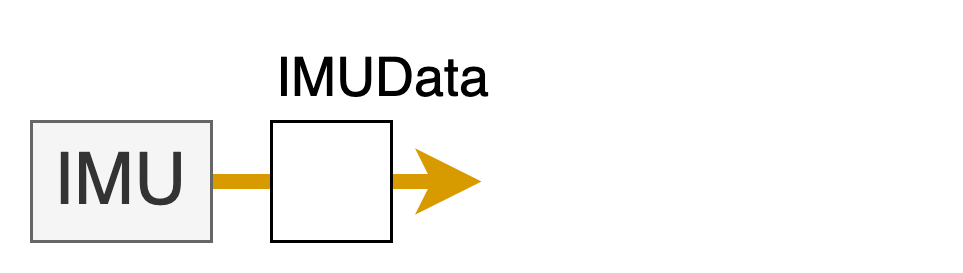

In [26]:
Image('IMUData.png', width=400)

In [27]:
# - Import and instantiate and IMUData module
from rockpool.devices.xylo.syns63300 import IMUData

mod = IMUData(db)
print(mod)

IMUData  with shape (0, 3)

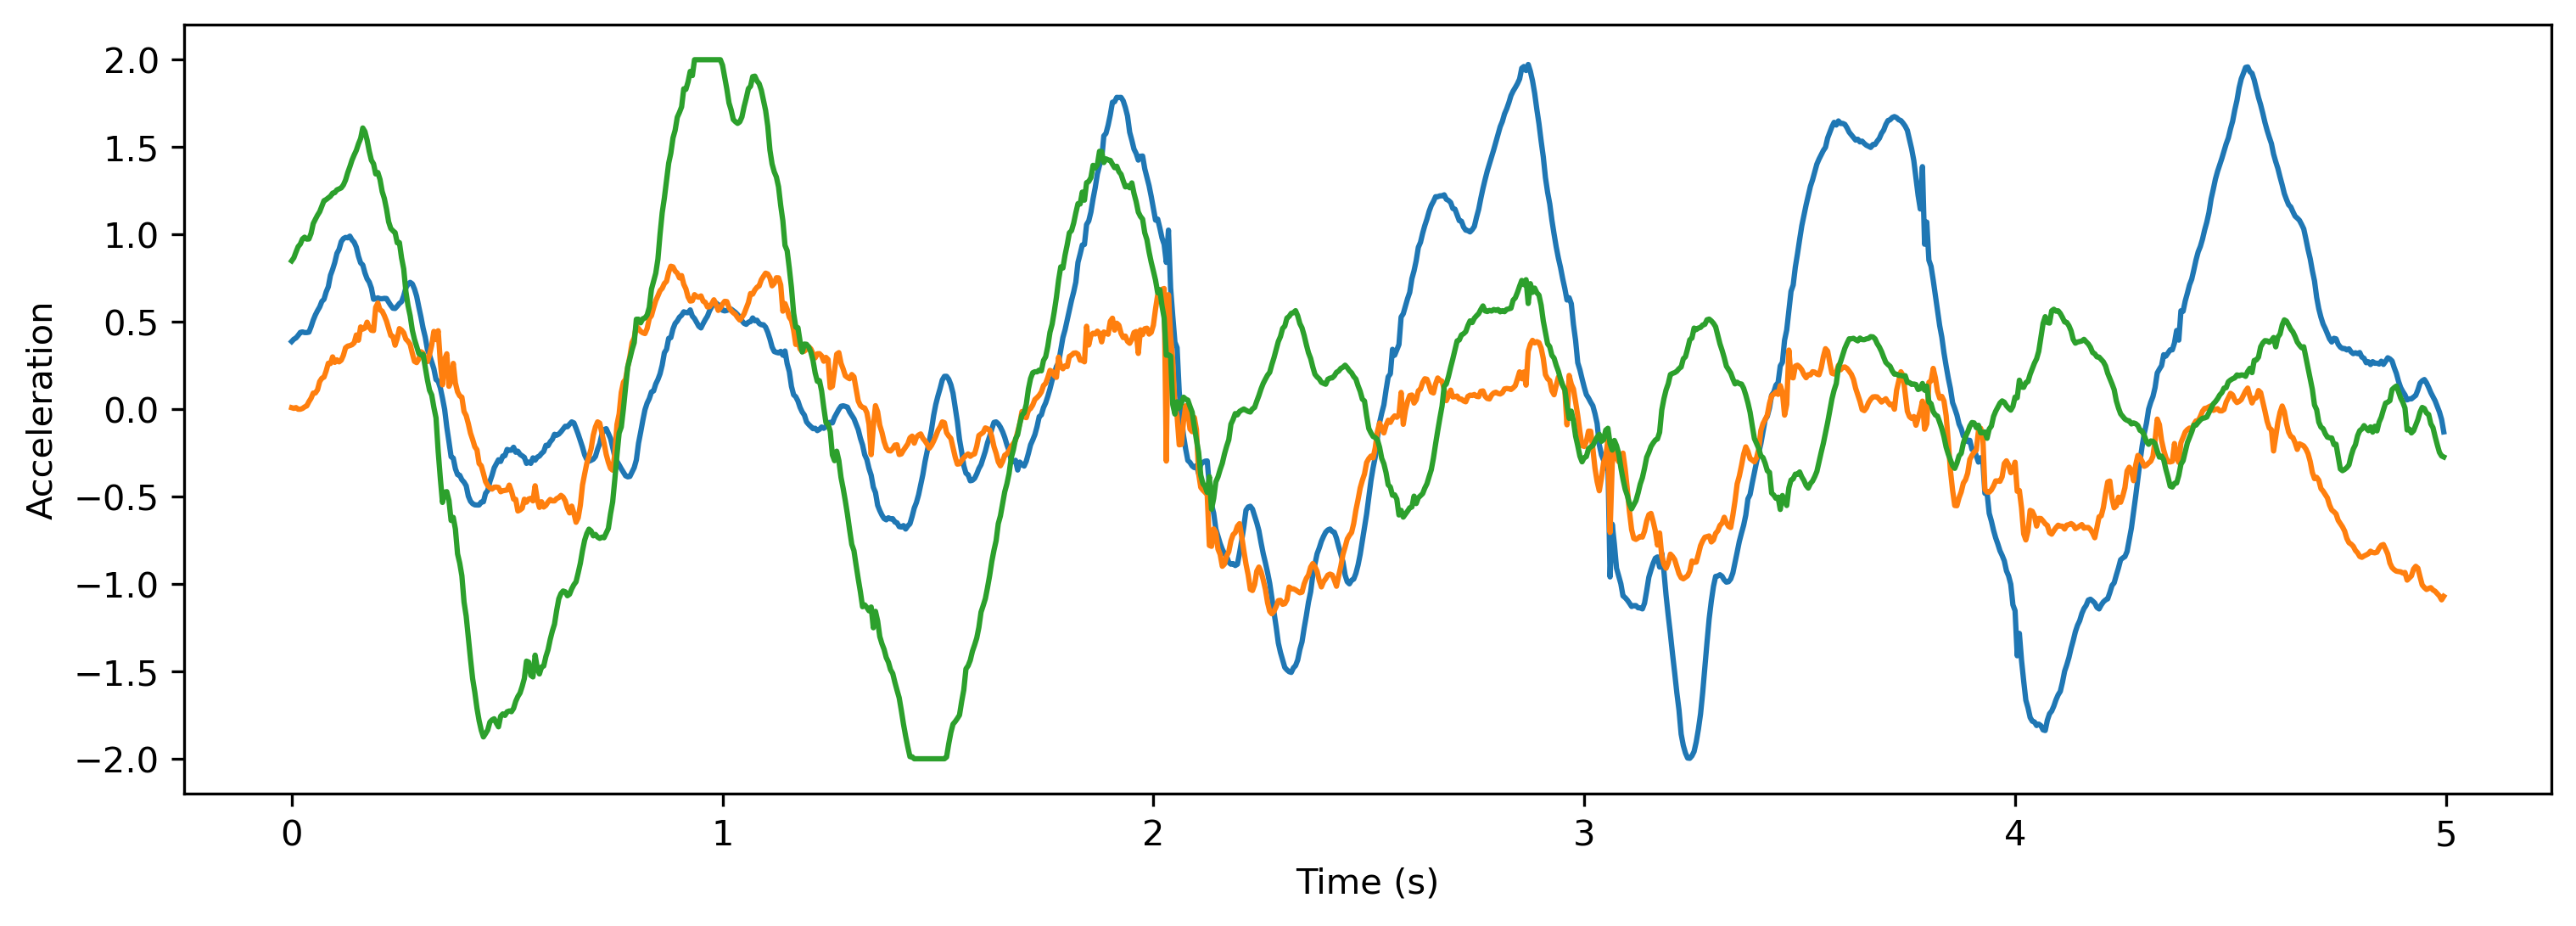

In [28]:
dt = mod.dt # By default Xylo IMU operates at 200 Hz
T = int(5. / dt) # Record for 5 seconds

# - Record live IMU sensor data
data, _, _ = mod(np.zeros((0, T, 0)))

# - Plot the data samples
times = np.arange(0, T) * mod.dt
plt.plot(times, data)
plt.xlabel('Time (s)')
plt.ylabel('Acceleration');

## PART IV: Real-time streaming mode

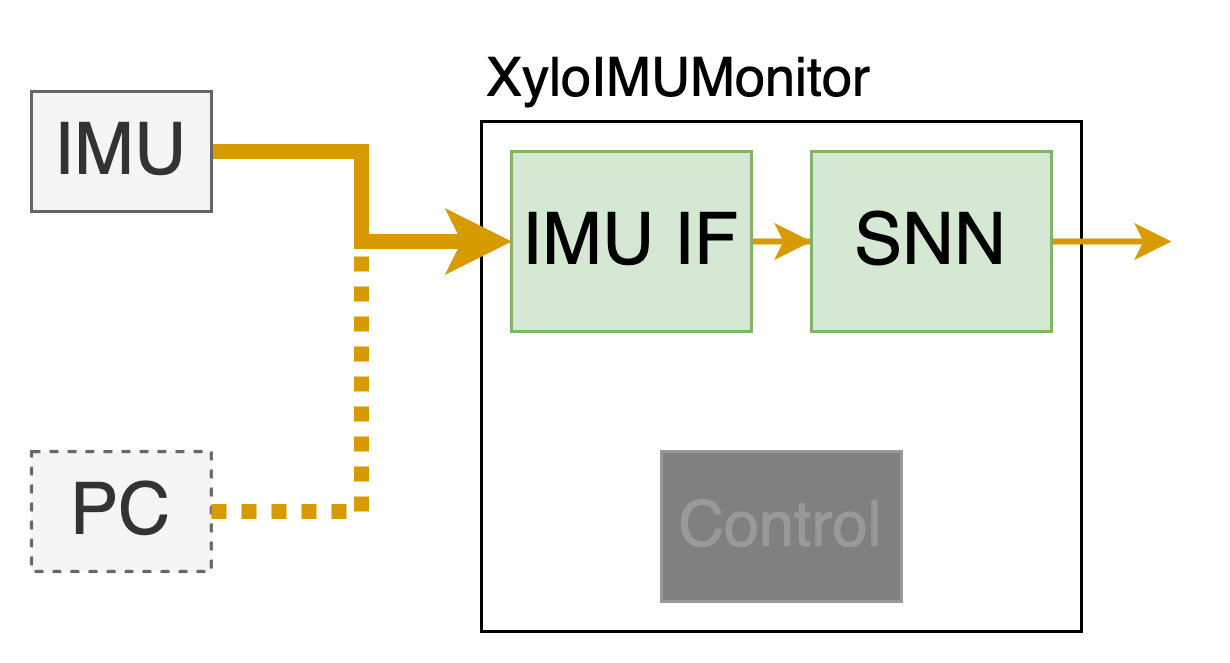

In [29]:
Image('XyloIMUMonitor.png', width = 400)

### Step 1: Build a network in rockpool and convert it to a hardware configuration

In [30]:
# - Define the size of the network layers
Nin = 15
Nhidden = 4
Nout = 2
dt = 1. / 200

In [31]:
# - Define the network architecture using combinators and modules
net = Sequential(
    LinearTorch((Nin, Nhidden), has_bias = False),
    LIFTorch(Nhidden, dt = dt),
    
    Residual(
        LinearTorch((Nhidden, Nhidden), has_bias = False),
        LIFTorch(Nhidden, has_rec = True, threshold = 1., dt = dt),
    ),
    
    LinearTorch((Nhidden, Nout), has_bias = False),
    LIFTorch(Nout, dt = dt),
)
print(net)

TorchSequential  with shape (15, 2) {
    LinearTorch '0_LinearTorch' with shape (15, 4)
    LIFTorch '1_LIFTorch' with shape (4, 4)
    TorchResidual '2_TorchResidual' with shape (4, 4) {
        LinearTorch '0_LinearTorch' with shape (4, 4)
        LIFTorch '1_LIFTorch' with shape (4, 4)
    }
    LinearTorch '3_LinearTorch' with shape (4, 2)
    LIFTorch '4_LIFTorch' with shape (2, 2)
}

In [32]:
# - Call the Xylo mapper on the extracted computational graph
spec = mapper(net.as_graph(),  weight_dtype='float', threshold_dtype='float', dash_dtype='float')

# - Quantize the specification
spec.update(q.global_quantize(**spec))

# # you can also try channel-wise quantization
# spec.update(q.channel_quantize(**spec))
# print(spec)

# - Use rockpool.devices.xylo.config_from_specification to convert it to a hardware configuration
config, is_valid, msg = config_from_specification(**spec)
if not is_valid:
    print(msg)

### Step 2: Deploy the network on chip and run simulation

In [36]:
# - Find and connect to a Xylo IMU HDK
xylo_hdk_nodes, _, vers = find_xylo_hdks()
print(xylo_hdk_nodes, vers)

if len(xylo_hdk_nodes) == 0 or vers[0] != 'syns63300':
    assert False, 'This tutorial requires a connected Xylo IMU HDK to demonstrate.'
else:
    db = xylo_hdk_nodes[0]

The connected Xylo HDK contains a Xylo IMU. Importing `rockpool.devices.xylo.syns63300`


[<samna.xyloImuBoards.XyloImuTestBoard object at 0x3508e55b0>]
['syns63300']

In [37]:
# - Use the `XyloIMUMonitor` module to deploy to the HDK, running in real time
from rockpool.devices.xylo.syns63300 import XyloIMUMonitor

output_mode = "Vmem"

modMonitor = XyloIMUMonitor(device=db, config=config, dt=dt, output_mode=output_mode)

In [38]:
# - A resultList stack to store the results
from IPython.display import clear_output

class ResultList(object):
    def __init__(self, max_len=100):
        self._list = []
        self.max_len = max_len

    def reset(self):
        self._list = []

    def append(self, num):
        if len(self._list) < self.max_len:
            self._list.append(num)
        else:
            self._list[: self.max_len - 1] = self._list[1:]
            self._list[self.max_len - 1] = num

    def is_full(self):
        if len(self._list) == self.max_len:
            return True
        else:
            return False

    def counts(self, features=[]):
        count = 0
        for _ in self._list:
            if _ in features:
                count += 1
        return count

    def __len__(self):
        return len(self._list)

    @property
    def list(self):
        return self._list

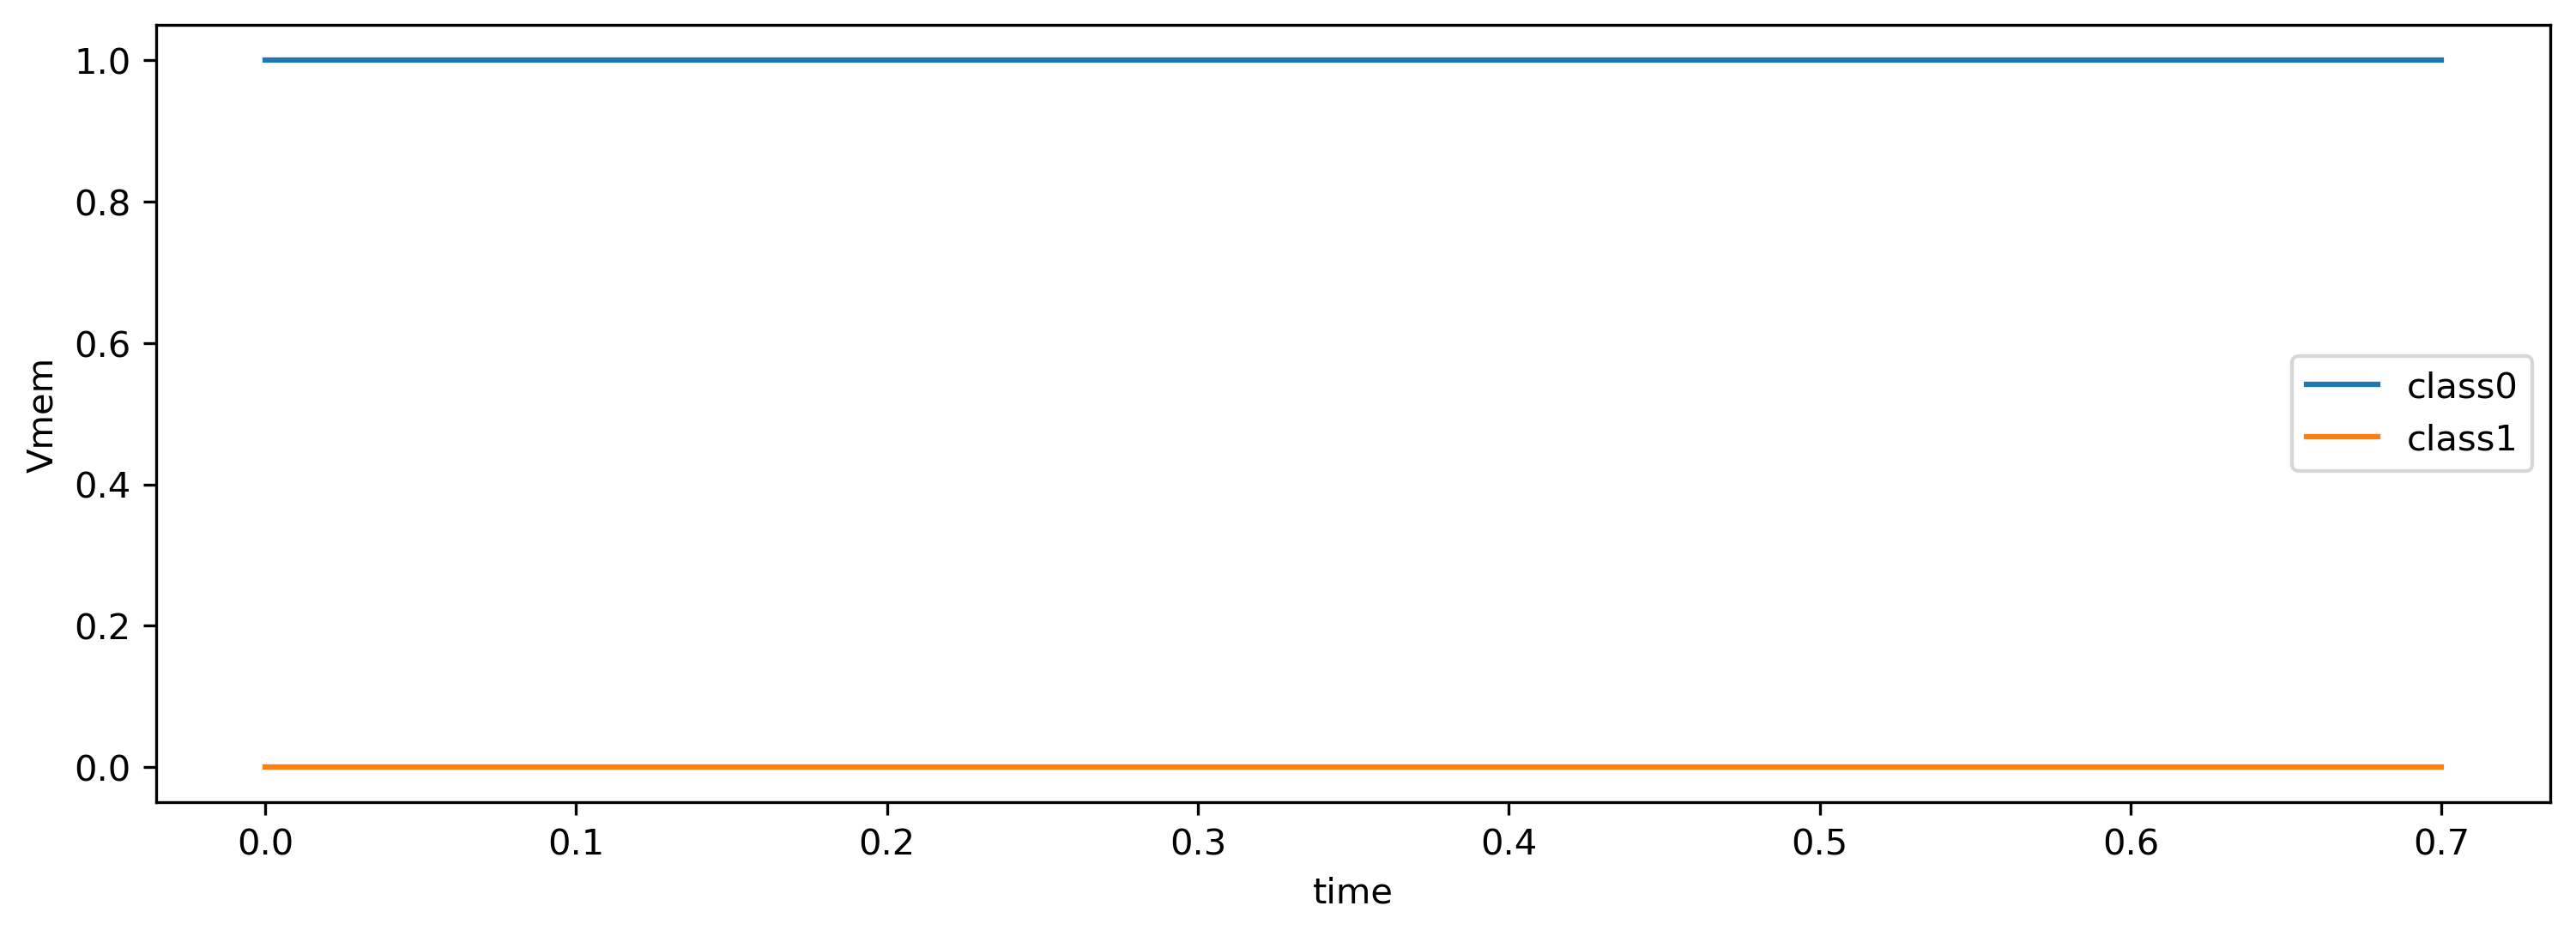

In [39]:
# - Draw a real time image for output channels, you can shake the Xylo IMU device while running

lines = [ResultList(max_len=10) for _ in range(Nout)]
time_base = ResultList(max_len=10)
tt = 0
T = 200
t_inference = 10.

from time import time

t_start = time()

while (time() - t_start) < t_inference:
    # - Perform inference on the Xylo IMU HDK
    output, _, _ = modMonitor(input_data=np.zeros((T, 3)))
    if output is not None:
        output = np.max(output, axis=0)
        for i in range(Nout):
            lines[i].append(output[i])

        time_base.append(tt)
        tt += 0.1
        ax_time = time_base.list
        
        for i in range(Nout):
            plt.plot(ax_time, lines[i].list, label=f"class{i}")

        plt.xlabel('time')
        plt.ylabel('Vmem')
        plt.legend()
        plt.pause(0.1)
        clear_output(wait=True)

## Part V: Measuring power on the Xylo HDK

In [42]:
# - Find and connect to a Xylo IMU HDK
xylo_hdk_nodes, modules, versions = find_xylo_hdks()
print(xylo_hdk_nodes, versions)

if len(xylo_hdk_nodes) == 0 or versions[0] is not 'syns63300':
    assert False, 'This tutorial requires a connected Xylo IMU HDK to demonstrate.'
else:
    db = xylo_hdk_nodes[0]
    x = modules[0]

The connected Xylo HDK contains a Xylo IMU. Importing `rockpool.devices.xylo.syns63300`


[<samna.xyloImuBoards.XyloImuTestBoard object at 0x3508e55b0>]
['syns63300']

In [43]:
# - Set a low clock frequency for the Xylo device
print(f'Setting Xylo main clock to {x.xylo_imu_devkit_utils.set_xylo_core_clock_freq(db, 6.25)} MHz')

# - Use XyloSamna to deploy to the HDK
modSamna = x.XyloSamna(db, config, dt = 10e-3, power_frequency=20.)
print(modSamna)

Setting Xylo main clock to 6.25 MHz

XyloSamna  with shape (15, 4, 2)

In [45]:
# - Generate some Poisson input
T = 1000
f = 0.4
input_spikes = np.random.rand(T, Nin) < f

# - Evolve some input on the SNN core, and record power during inference
out, _, record_dict = modSamna(input_spikes, record_power = True)

print(record_dict)

{
    'io_power': array([0.0003336 , 0.00032705, 0.00033385, 0.00033586, 0.00033284,
       0.00033083, 0.00032629, 0.00034039]),
    'core_power': array([0.00019518, 0.00020046, 0.00021628, 0.00018991, 0.00019518,
       0.00021101, 0.00020046, 0.00020046])
}

In [46]:
print(f"Active IO power:\t{np.mean(record_dict['io_power']) * 1e6}µW\nSNN + IMU IF core:\t{np.mean(record_dict['core_power']) * 1e6}µW")

Active IO power:        332.58819580078125µW
SNN + IMU IF core:      201.11628941127233µW

In [47]:
# - Measure idle power (no evolution)
from time import sleep

modSamna._power_buf.clear_events()
sleep(5.)
power = modSamna._power_buf.get_events()

power_idle = ([], [])

for p in power:
    power_idle[p.channel].append(p.value)

idle_power_per_channel = np.mean(np.stack(power_idle), axis = 1)

print(f'Idle IO power:\t\t{idle_power_per_channel[0] * 1e6}µW\nSNN + IMU IF core:\t{idle_power_per_channel[1]*1e6}µW')

Idle IO power:          334.30778503417963µW
SNN + IMU IF core:      188.16571916852678µW

### Hints on reducing power consumption

In [48]:
help(x.xylo_imu_devkit_utils.set_xylo_core_clock_freq)

Help on function set_xylo_core_clock_freq in module rockpool.devices.xylo.syns63300.xylo_imu_devkit_utils:

set_xylo_core_clock_freq(device: samna.xyloImuBoards.XyloImuTestBoard, desired_freq_MHz: float) -> float
    Set the inference core clock frequency used by Xylo
    
    Args:
        device (XyloIMUHDK): A Xylo device to configure
        desired_freq_MHz (float): The desired Xylo core clock frequency in MHz
    
    Returns:
        (float): Actual frequency obtained, in MHz



### Estimate the required master clock frequency for real-time operation

In [49]:
from rockpool.devices.xylo.syns63300 import cycles_model, est_clock_freq

help(cycles_model)

Help on function cycles_model in module rockpool.devices.xylo.syns63300.power_cycles_model:

cycles_model(config: samna.xyloImu.configuration.XyloConfiguration, input_sp: Union[float, numpy.ndarray, torch.Tensor, array] = 1.0, hidden_sp: Union[float, numpy.ndarray, torch.Tensor, array] = 1.0, output_sp: Union[float, numpy.ndarray, torch.Tensor, array] = 1.0) -> float
    Calculate the average number of cycles required for a given network architecture
    
    This function contains a model which estimates the number of master clock cycles required for the Xylo SNN SYNS61202 inference core to compute one time-step for a given chip configuration in ``config``. Use :py:func:`.devices.xylo.syns61201.config_from_specification` to obtain a chip configuration, along with :py:meth:`.Module.as_graph` and :py:func:`.devices.xylo.syns61201.mapper`, as described in the deployment tutorials for Xylo.
    
    By default the model provides a "worst-case" estimation, assuming that every neuron and ev

In [50]:
help(est_clock_freq)

Help on function est_clock_freq in module rockpool.devices.xylo.syns63300.power_cycles_model:

est_clock_freq(config: samna.xyloImu.configuration.XyloConfiguration, dt: float, margin: float = 0.2)
    Estimate the required master clock frequency, to run a network in real-time
    
    This function will perform a worst-case analysis, assuming that every input channel, every hidden neuron and every output neuron fire an event on each `dt`. An additional margin is included (Default: 20%), to guarantee that the model will run in real time at the suggested master clock frequency.
    
    Args:
        config (XyloIMUConfig):  A Xylo IMU configuration for which to estimate the required clock frequency
        dt (float): The required network `dt`, in seconds
        margin (float): The additional overhead safety margin to add to the estimation, as a fraction. Default: `0.2` (20%)



In [51]:
print(f"This network requires {cycles_model(config)} master clock cycles per network time-step.")
print(f"This network requires a master clock of {est_clock_freq(config, dt) / 1e6:.2f} MHz for real-time operation.")

This network requires 757.0 master clock cycles per network time-step.

This network requires a master clock of 0.18 MHz for real-time operation.

## Next steps